In [2]:
%matplotlib notebook

In [3]:
import csv
import numpy as np
import pandas as pd
import math
import time


In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Read data

In [5]:
filename = "akash_home_walk_1.txt"

In [6]:
def GetData(filename):
    with open(filename) as f:
        lines = f.readlines()
    
    frame_num_count = -1
    frame_num = []
    x = []
    y = []
    z = []
    velocity = []
    intensity = []
    depth = []
    
    # Offset
    x_off = 0
    y_off = 4
    z_off = 8
    velocity_off = 24
    intensity_off = 16
    depth_off = 20
    point_step = 32
    
    for line in lines:
        # Find where data frames are
        if line[:5] == 'data:':
            frame_num_count += 1
            frame_data = line[7:-2].split(",")
            frame_data = np.asarray(frame_data)
            frame_data = frame_data.astype(np.uint8)
            
            init_pt1 = 0
            init_pt2 = point_step
            # Look at each point in the frame
            while init_pt2 <= len(frame_data):
                pt = frame_data[init_pt1:init_pt2]
                # Convert uint8 to float32
                x.append(float(pt[x_off:x_off+4].view('<f4')))
                y.append(float(pt[y_off:y_off+4].view('<f4')))
                z.append(float(pt[z_off:z_off+4].view('<f4')))
                velocity.append(float(pt[velocity_off:velocity_off+4].view('<f4')))
                intensity.append(float(pt[intensity_off:intensity_off+4].view('<f4')))
                depth.append(float(pt[depth_off:depth_off+4].view('<f4')))
                frame_num.append(frame_num_count)
                
                init_pt1 += point_step
                init_pt2 += point_step
    
    frame_num = np.asarray(frame_num)
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    velocity = np.asarray(velocity)
    intensity = np.asarray(intensity)

    data = pd.DataFrame()
    data['frame_num'] = frame_num.astype(np.int)
    data['x'] = x.astype(np.float)
    data['y'] = y.astype(np.float)
    data['z'] = z.astype(np.float)
    data['velocity'] = velocity.astype(np.float)
    data['intensity'] = intensity.astype(np.float)
    
    return data

In [7]:
data = GetData(filename)

In [8]:
data

frame_num         x         y         z  velocity  intensity
0              0  0.529297  0.287109  0.107422  0.000000  28.802418
1              0  0.566406  0.306641  0.111328  0.000000  30.413927
2              0  0.601562  0.328125  0.132812  0.000000  27.528164
3              0  0.537109  0.509766  0.050781  0.000000  22.504200
4              0  0.554688  0.515625  0.208984  0.000000  23.201464
...          ...       ...       ...       ...       ...        ...
53446        997  2.546875 -0.353516 -1.197266  0.750914   9.542425
53447        997  2.482422 -0.089844 -1.455078  0.750914  12.552725
53448        997  3.044922  0.095703  0.214844  0.750914  12.304489
53449        997  3.080078 -0.000000  0.316406  0.750914  11.760913
53450        997  3.125000 -0.197266  0.238281  0.750914  13.802113

[53451 rows x 6 columns]

In [9]:
data.describe()

frame_num             x             y             z      velocity  \
count  53451.000000  53451.000000  53451.000000  53451.000000  53451.000000   
mean     496.746104      2.185586      0.068856     -0.193606      0.169431   
std      288.000754      1.469322      0.908423      0.552115      0.330212   
min        0.000000      0.001953     -4.816406     -4.794922     -1.752133   
25%      247.000000      0.994141     -0.109375     -0.537109      0.000000   
50%      497.000000      2.179688      0.169922     -0.246094      0.250305   
75%      745.500000      2.964844      0.564453      0.062500      0.250305   
max      997.000000      4.972656      4.775391      4.734375      1.752133   

          intensity  
count  53451.000000  
mean      17.519895  
std        5.204398  
min        3.010300  
25%       13.617278  
50%       17.853298  
75%       20.969101  
max       32.552727

# Small tool functions

In [10]:
def Normalize(x, x_min, x_max):
    return (x-x_min)/(x_max-x_min)

In [11]:
# Normalize a list of intensity to [0,1] as weights
from sklearn.preprocessing import MinMaxScaler
def Weight(datalist):
    return MinMaxScaler().fit_transform(np.asarray(datalist.intensity).reshape(-1,1)).reshape(1,-1)[0]

In [12]:
# Reshape numpy arrays
def HorToVer(array):
    return array.reshape(-1,1)
def VerToHor(array):
    return array.reshape(1,-1)

In [13]:
# Angle between two vectors (0-1, 0=vertical, 1=parallel direction (same or opposite))
def VectorAngle(vec1, vec2):
    return np.abs(np.dot(vec1, vec2))/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [14]:
# Transform between cartesian and spherical coodinates
# theta: 0~2 pi, phi: 0~pi

def CarToSph(x, y, z):
    R = np.sqrt(x**2+y**2+z**2)
    theta = np.arctan2(y, x)
    if theta < 0:
        theta += 2*np.pi
    phi = np.arctan2(np.sqrt(x**2+y**2), z)
    return R, theta, phi

def SphToCar(R, theta, phi):
    x = R * np.cos(theta) * np.sin(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(phi)
    return x, y, z

In [15]:
def GetColors(label_list):
    color_list = ['r', 'b', 'g', 'c', 'm', 'darkorange', 'deepskyblue', 'blueviolet', 'crimson', 'orangered', 'k']
    return list(map(lambda x: color_list[x], label_list))


# Plot data points

In [16]:
# alpha = 'none', 'intensity', 'velocity'
def PlotData(ax, datalist, **kwargs):
    datalist = datalist.reset_index()

    if 'color' not in kwargs.keys():
        kwargs['color'] = ['k']*len(datalist)
    elif len(kwargs['color']) != len(datalist):
        kwargs['color'] = list(kwargs['color'])*len(datalist)

    if 'alpha' in kwargs.keys() and kwargs['alpha'] in ['intensity', 'velocity']:
        weight_min = np.min(np.abs(datalist[kwargs['alpha']]))
        weight_max = np.max(np.abs(datalist[kwargs['alpha']]))
    
        for i in range(len(datalist)):
            ax.scatter(datalist.x[i], datalist.y[i], datalist.z[i], color = kwargs['color'][i], alpha = Normalize(datalist.loc[i][kwargs['alpha']], weight_min, weight_max), marker = '.')
    else:
        for i in range(len(datalist)):
            ax.scatter(datalist.x[i], datalist.y[i], datalist.z[i], color = kwargs['color'][i], marker = '.')


In [17]:
# Plot settings
def PlotSetting(ax):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # ax.set_xlim(-1, 5)
    # ax.set_ylim(-1, 2)
    # ax.set_zlim(-0.5, 1.5)

# Choose frame window

In [18]:
WINDOW = 5

In [49]:
# How many data points in each frame
frame_point_count = []
for i in range(np.max(data.frame_num)+1):
    frame_point_count.append(len(data[data.frame_num==i]))

pd.Series(frame_point_count).describe()

count    998.000000
mean      53.558116
std        1.525487
min       47.000000
25%       53.000000
50%       54.000000
75%       54.000000
max       59.000000
dtype: float64

In [83]:
# How many data points in each 5-frame window
frame_point_count = []
for i in range(int(np.max(data.frame_num)/WINDOW)):
    frame_point_count.append(len(data[(data.frame_num>=i*WINDOW)&(data.frame_num<(i+1)*WINDOW)]))

pd.Series(frame_point_count).describe()

count    199.000000
mean     267.804020
std        5.223953
min      243.000000
25%      265.500000
50%      269.000000
75%      270.000000
max      289.000000
dtype: float64

<IPython.core.display.Javascript object>


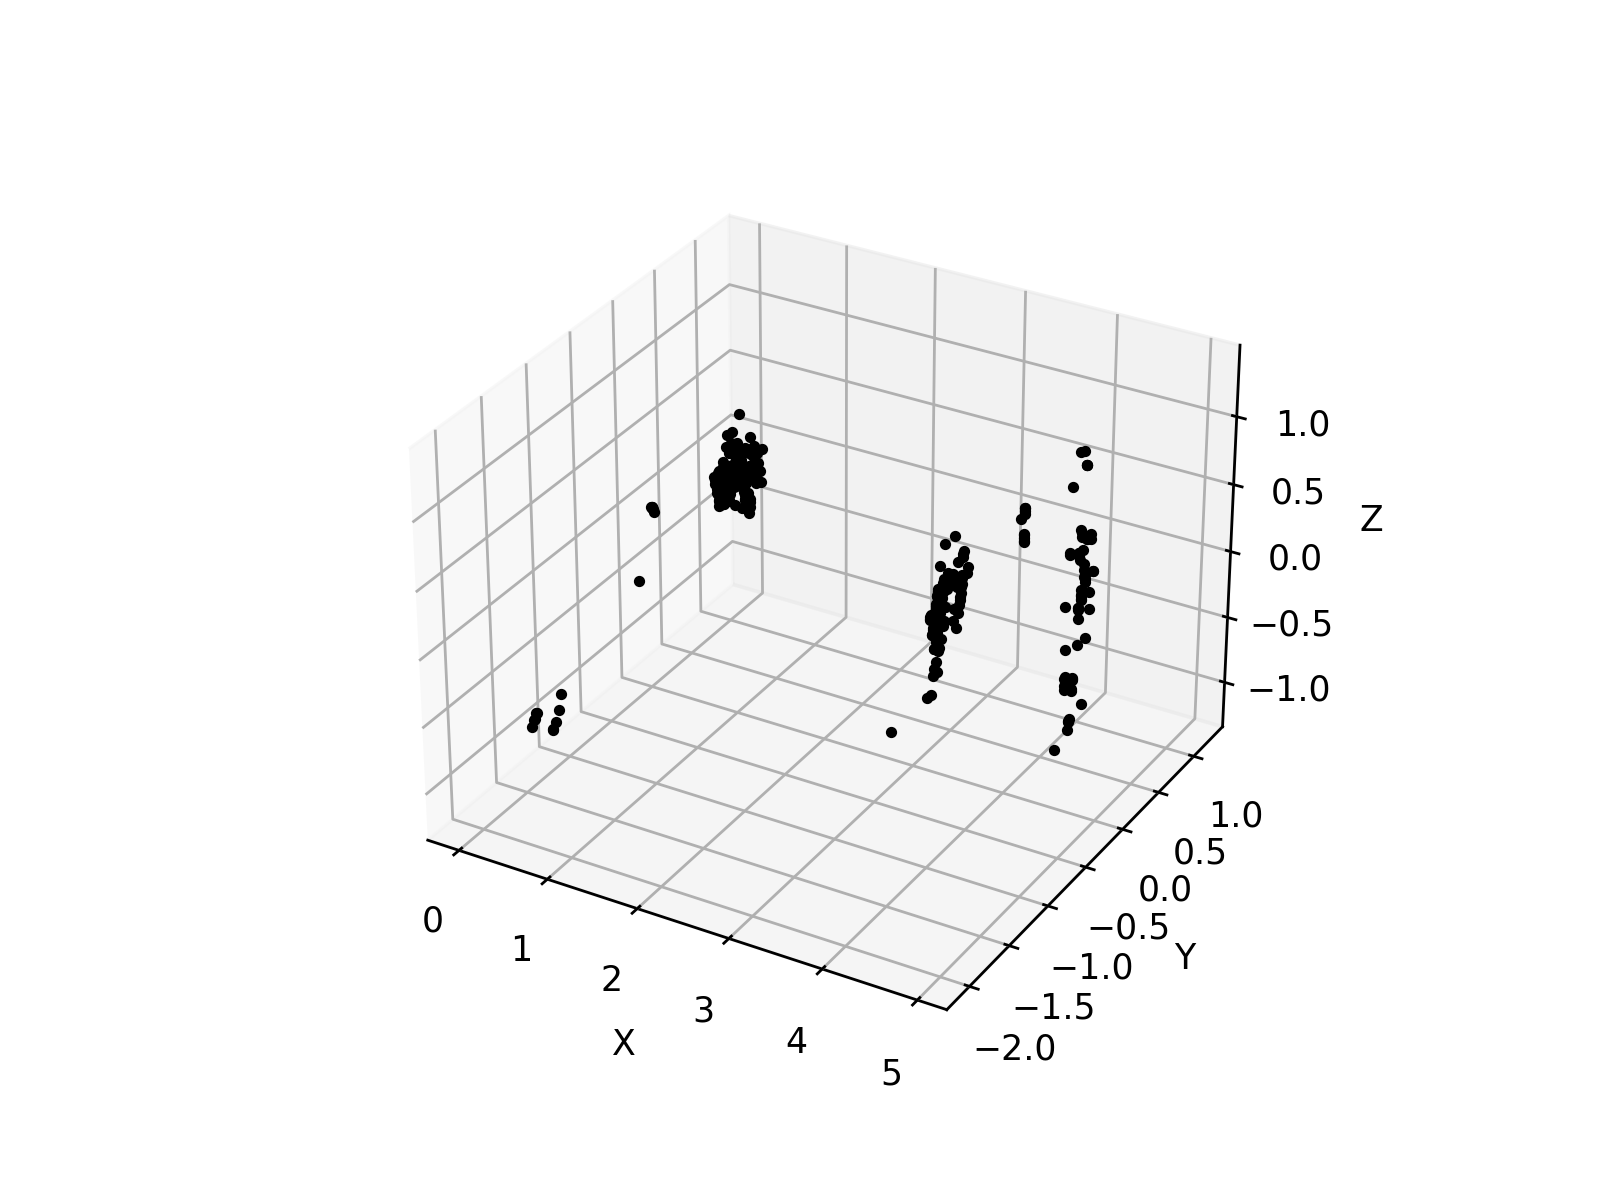

In [489]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

PlotData(ax, data[data.frame_num<5])

plt.show()

# DBSCAN clustering

In [19]:
from sklearn.cluster import DBSCAN

In [20]:
def ModelCluster(datalist, model, sample_weight=True, show_plot=True, return_cluster=False):
    if sample_weight:
        sample_weight = Weight(datalist)
    else:
        sample_weight = None
    clustering = model.fit(np.asarray(datalist.iloc[:,1:4]), sample_weight = sample_weight)
    
    if show_plot:
        fig = plt.figure()
        ax = fig.gca(projection = '3d')
        PlotSetting(ax)
        
        PlotData(ax, datalist, color = GetColors(clustering.labels_))
        
        plt.show()
    
    if return_cluster:
        return clustering

## Compare with and without sample_weight

<IPython.core.display.Javascript object>


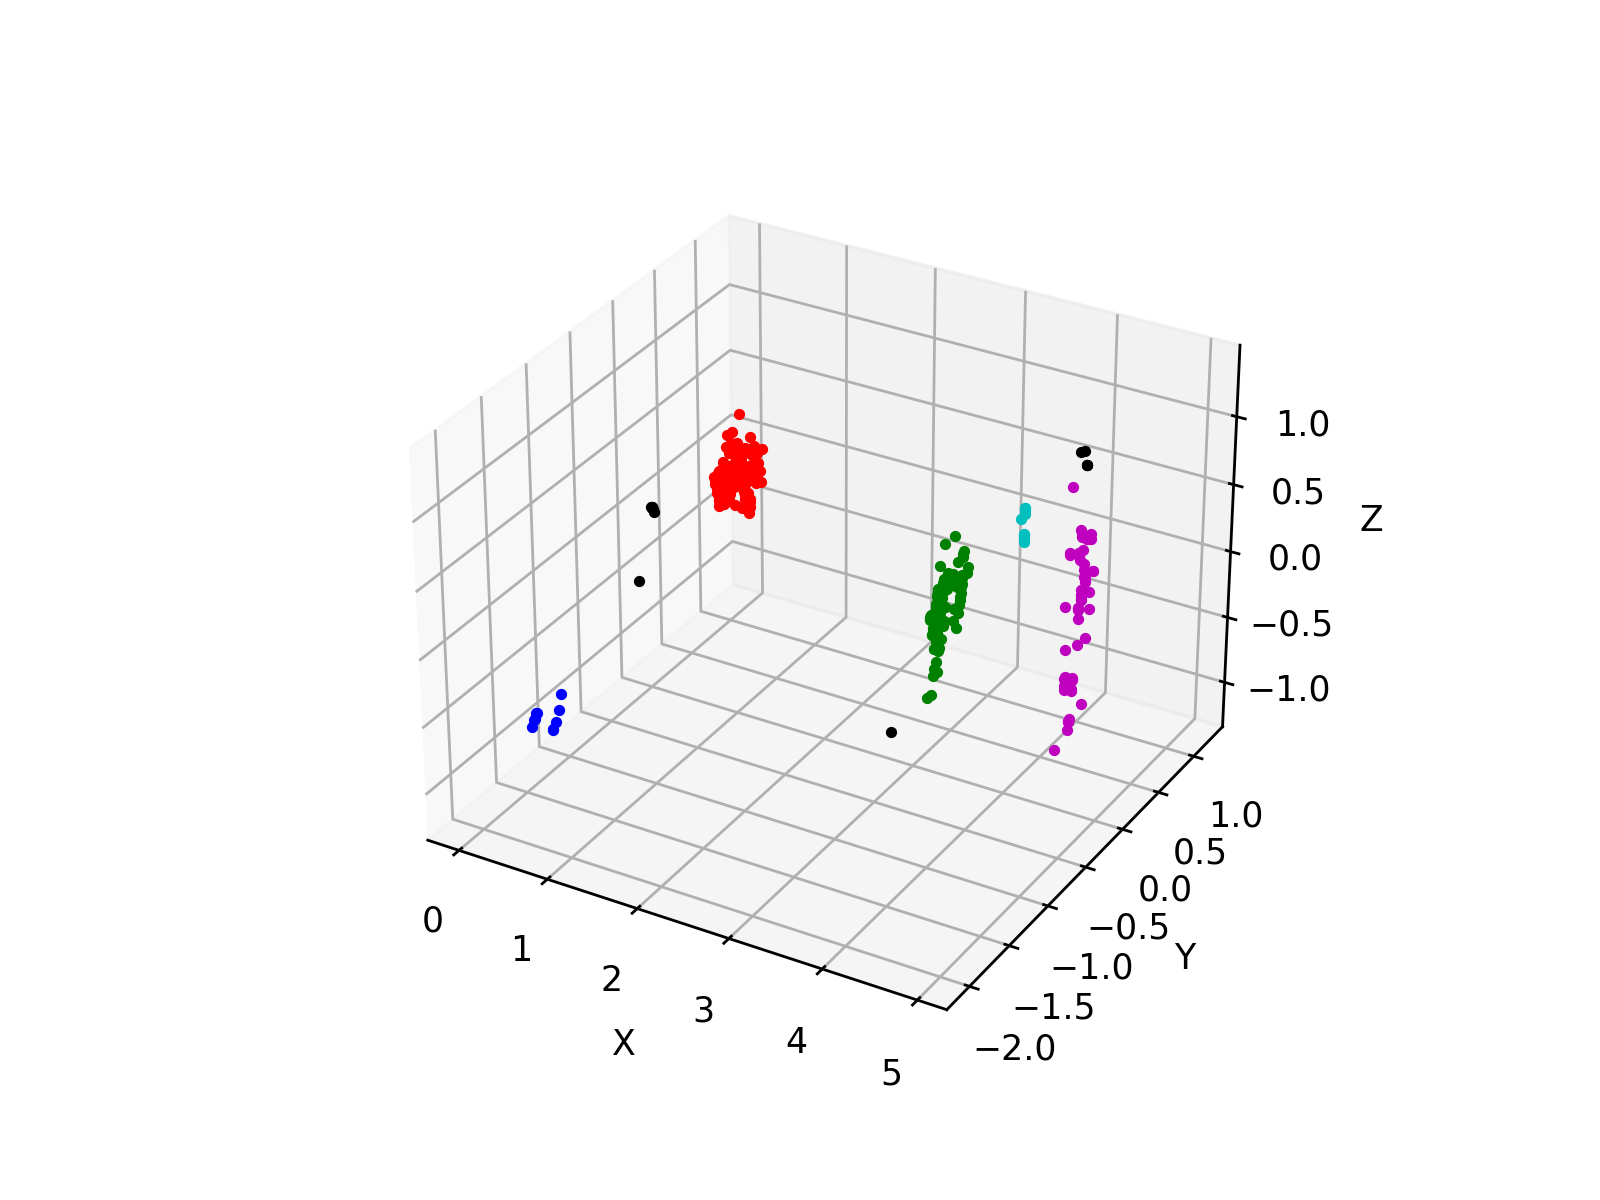

<IPython.core.display.Javascript object>


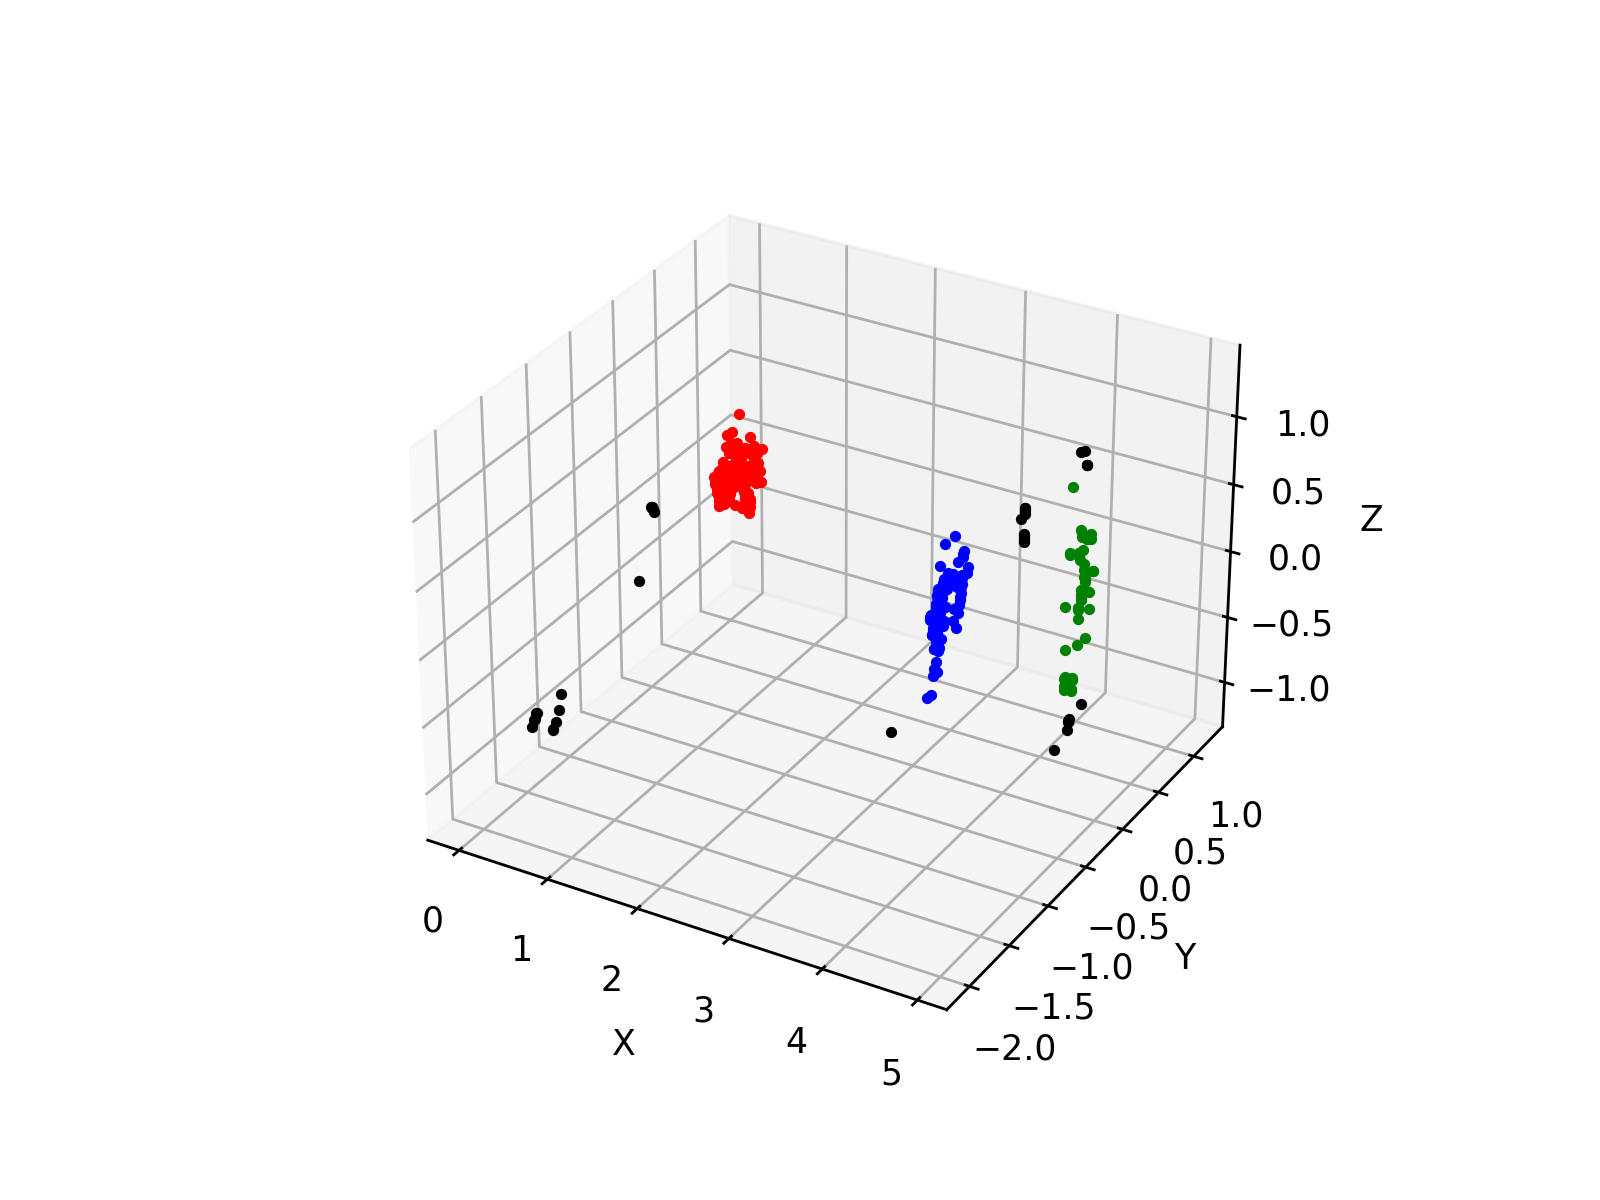

In [261]:
# Clustering frame_num = 0~4
startFrame = 0
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

ModelCluster(datalist, dbscan, sample_weight=False)
ModelCluster(datalist, dbscan, sample_weight=True)

<IPython.core.display.Javascript object>


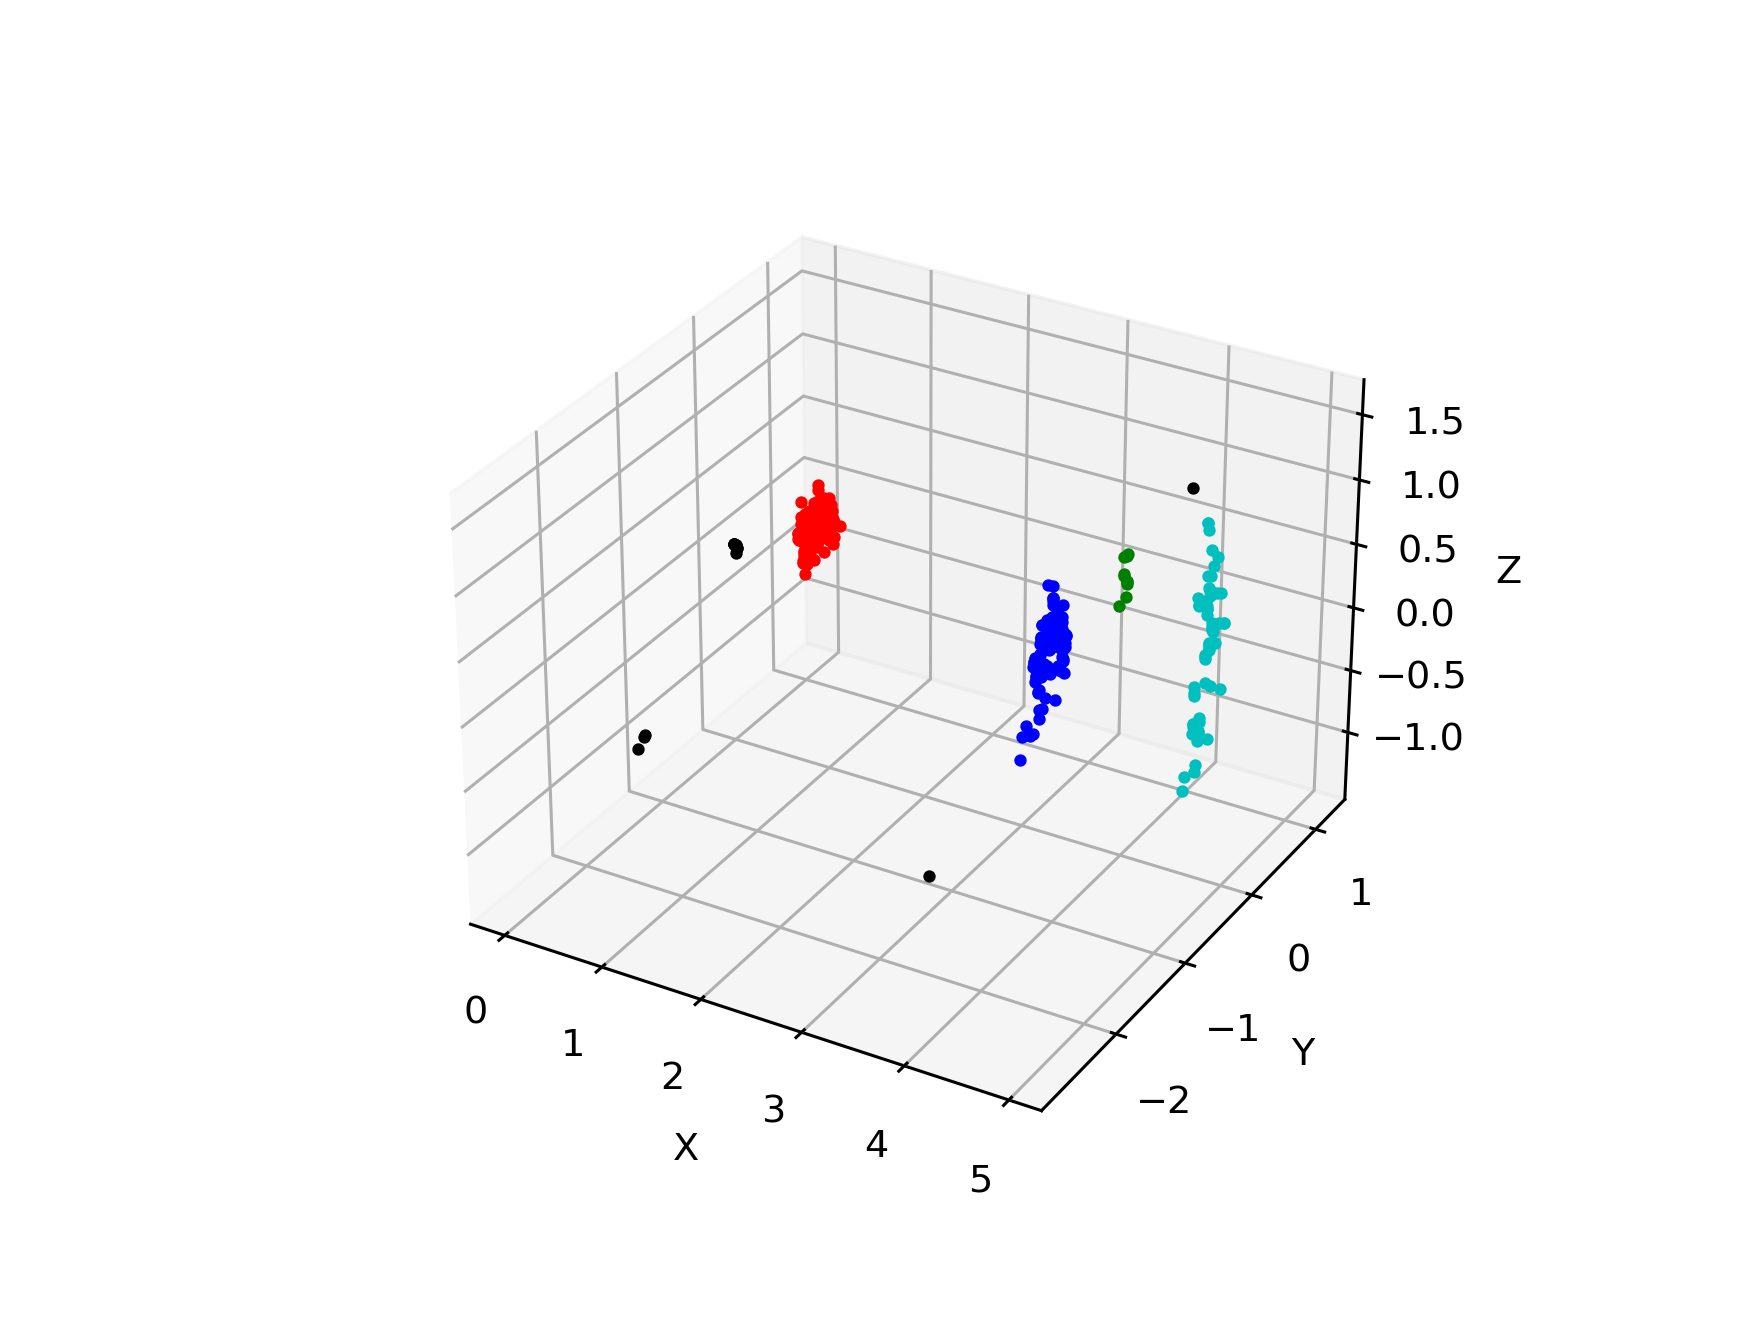

<IPython.core.display.Javascript object>


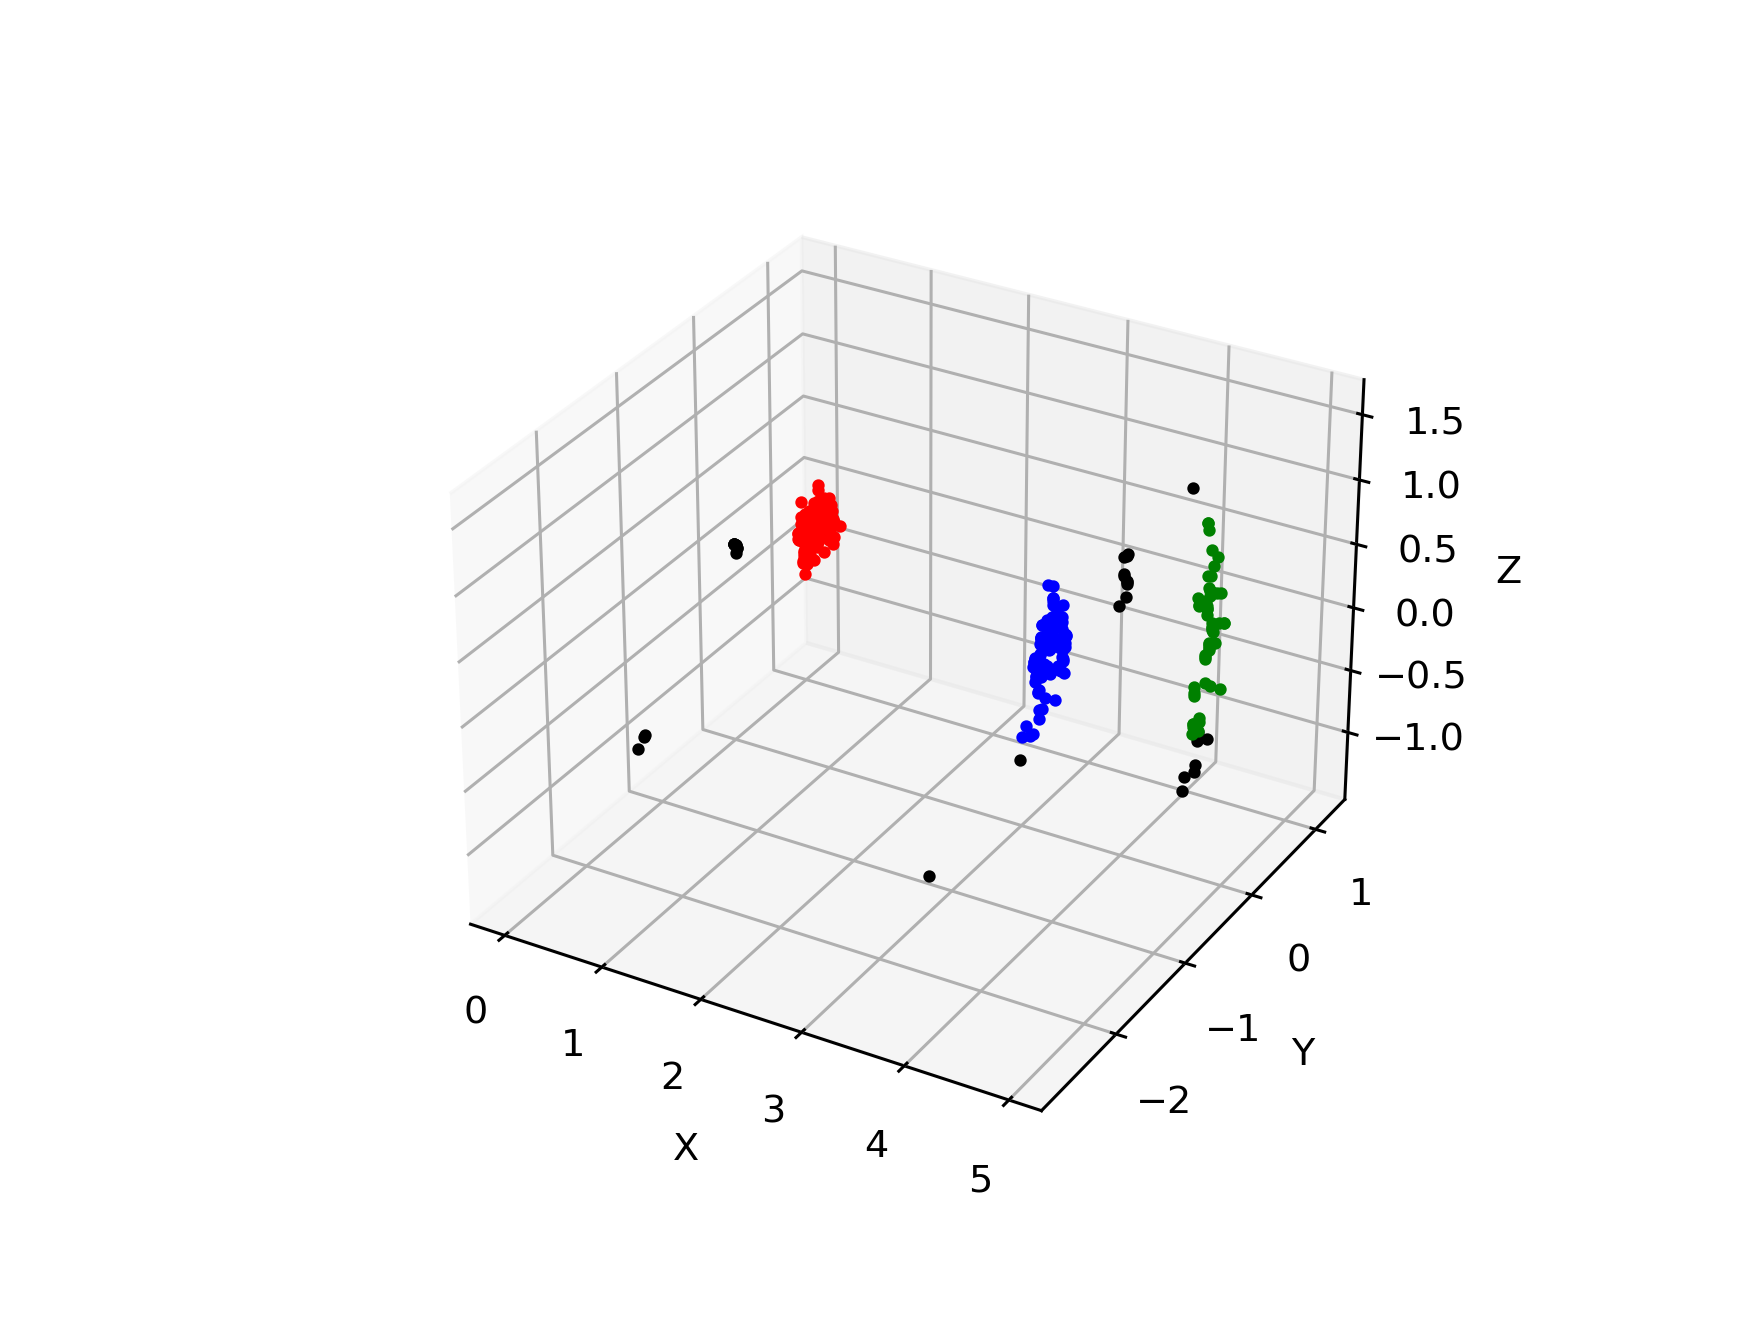

In [203]:
# Clustering frame_num = 5~9
startFrame = 5
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

ModelCluster(datalist, dbscan, sample_weight=False)
ModelCluster(datalist, dbscan, sample_weight=True)

<IPython.core.display.Javascript object>


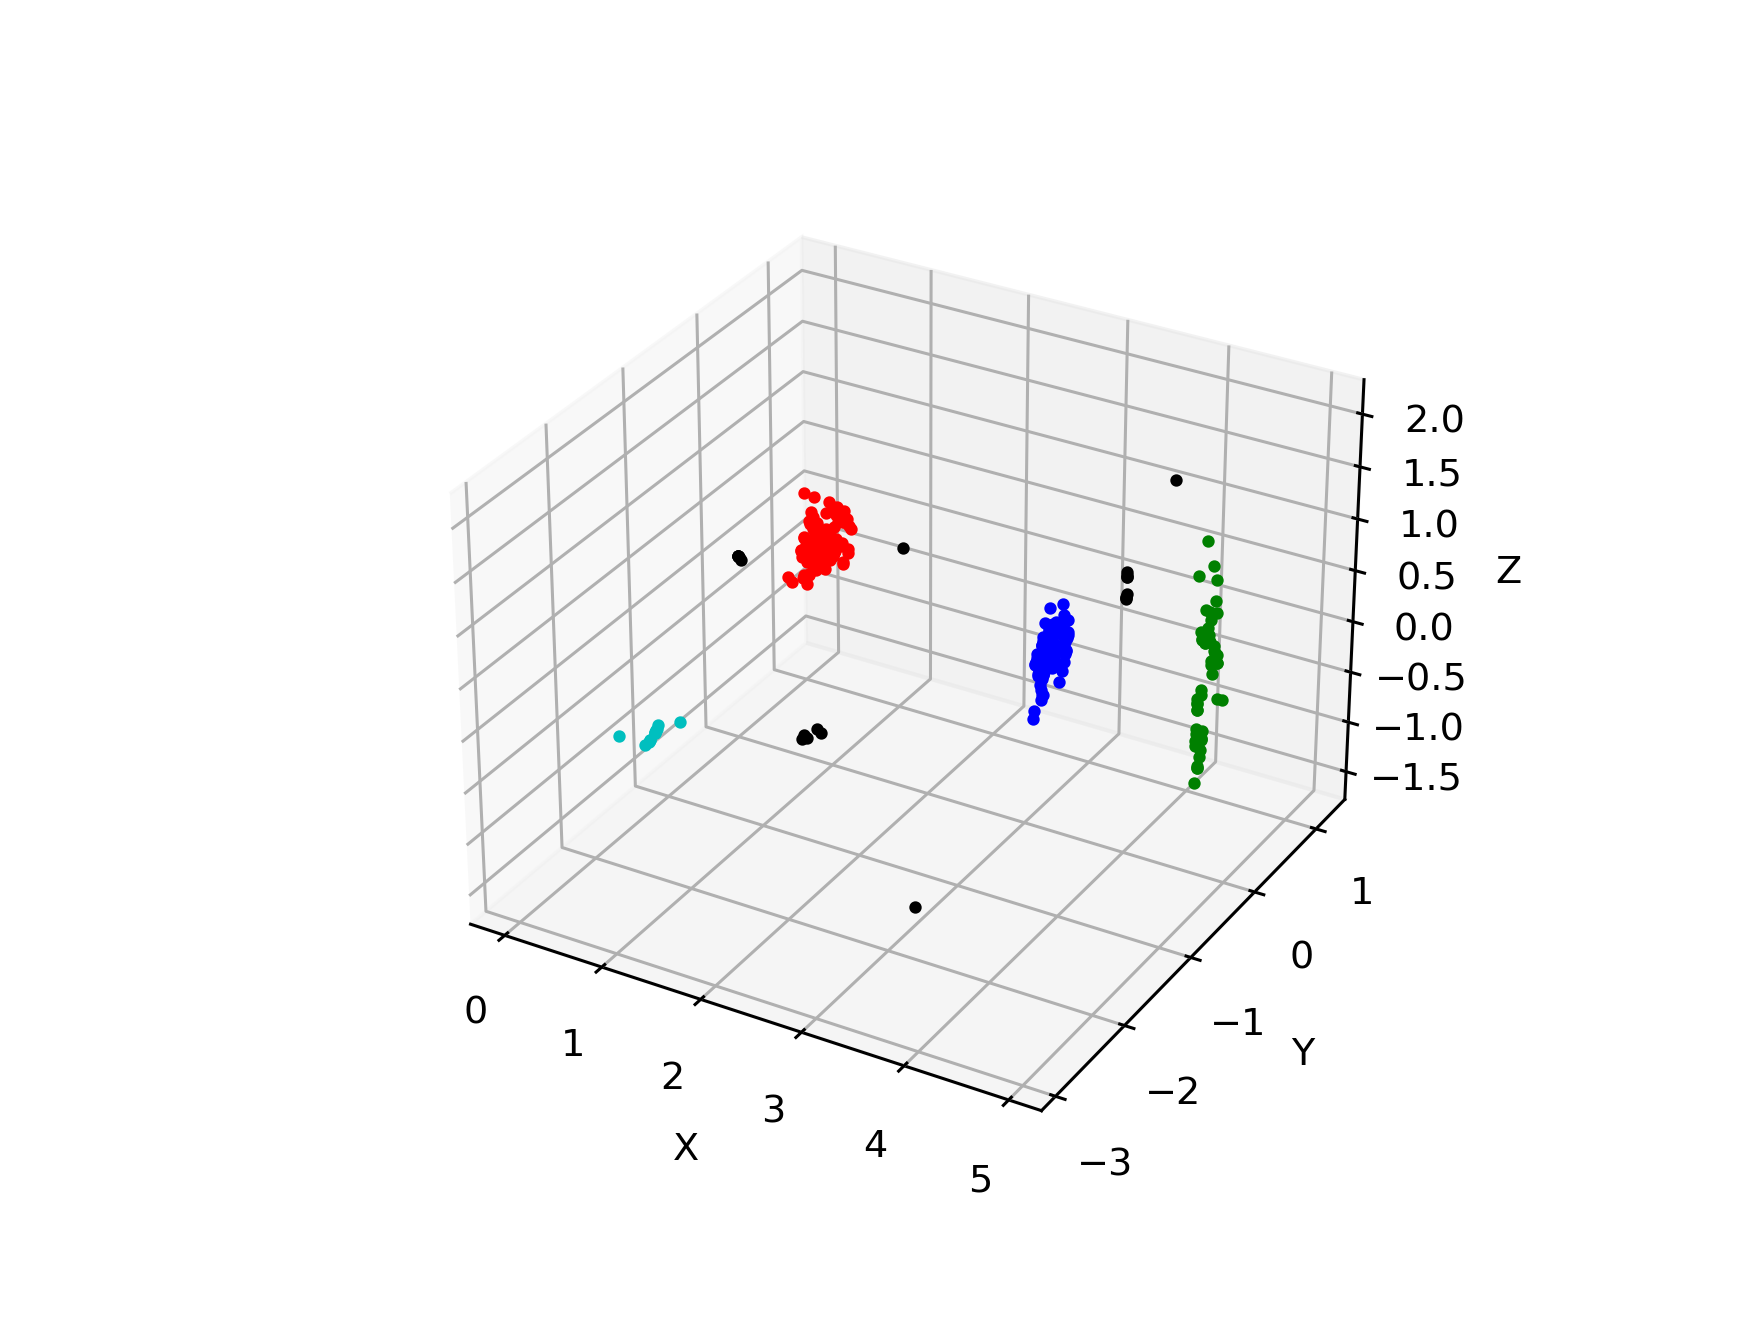

<IPython.core.display.Javascript object>


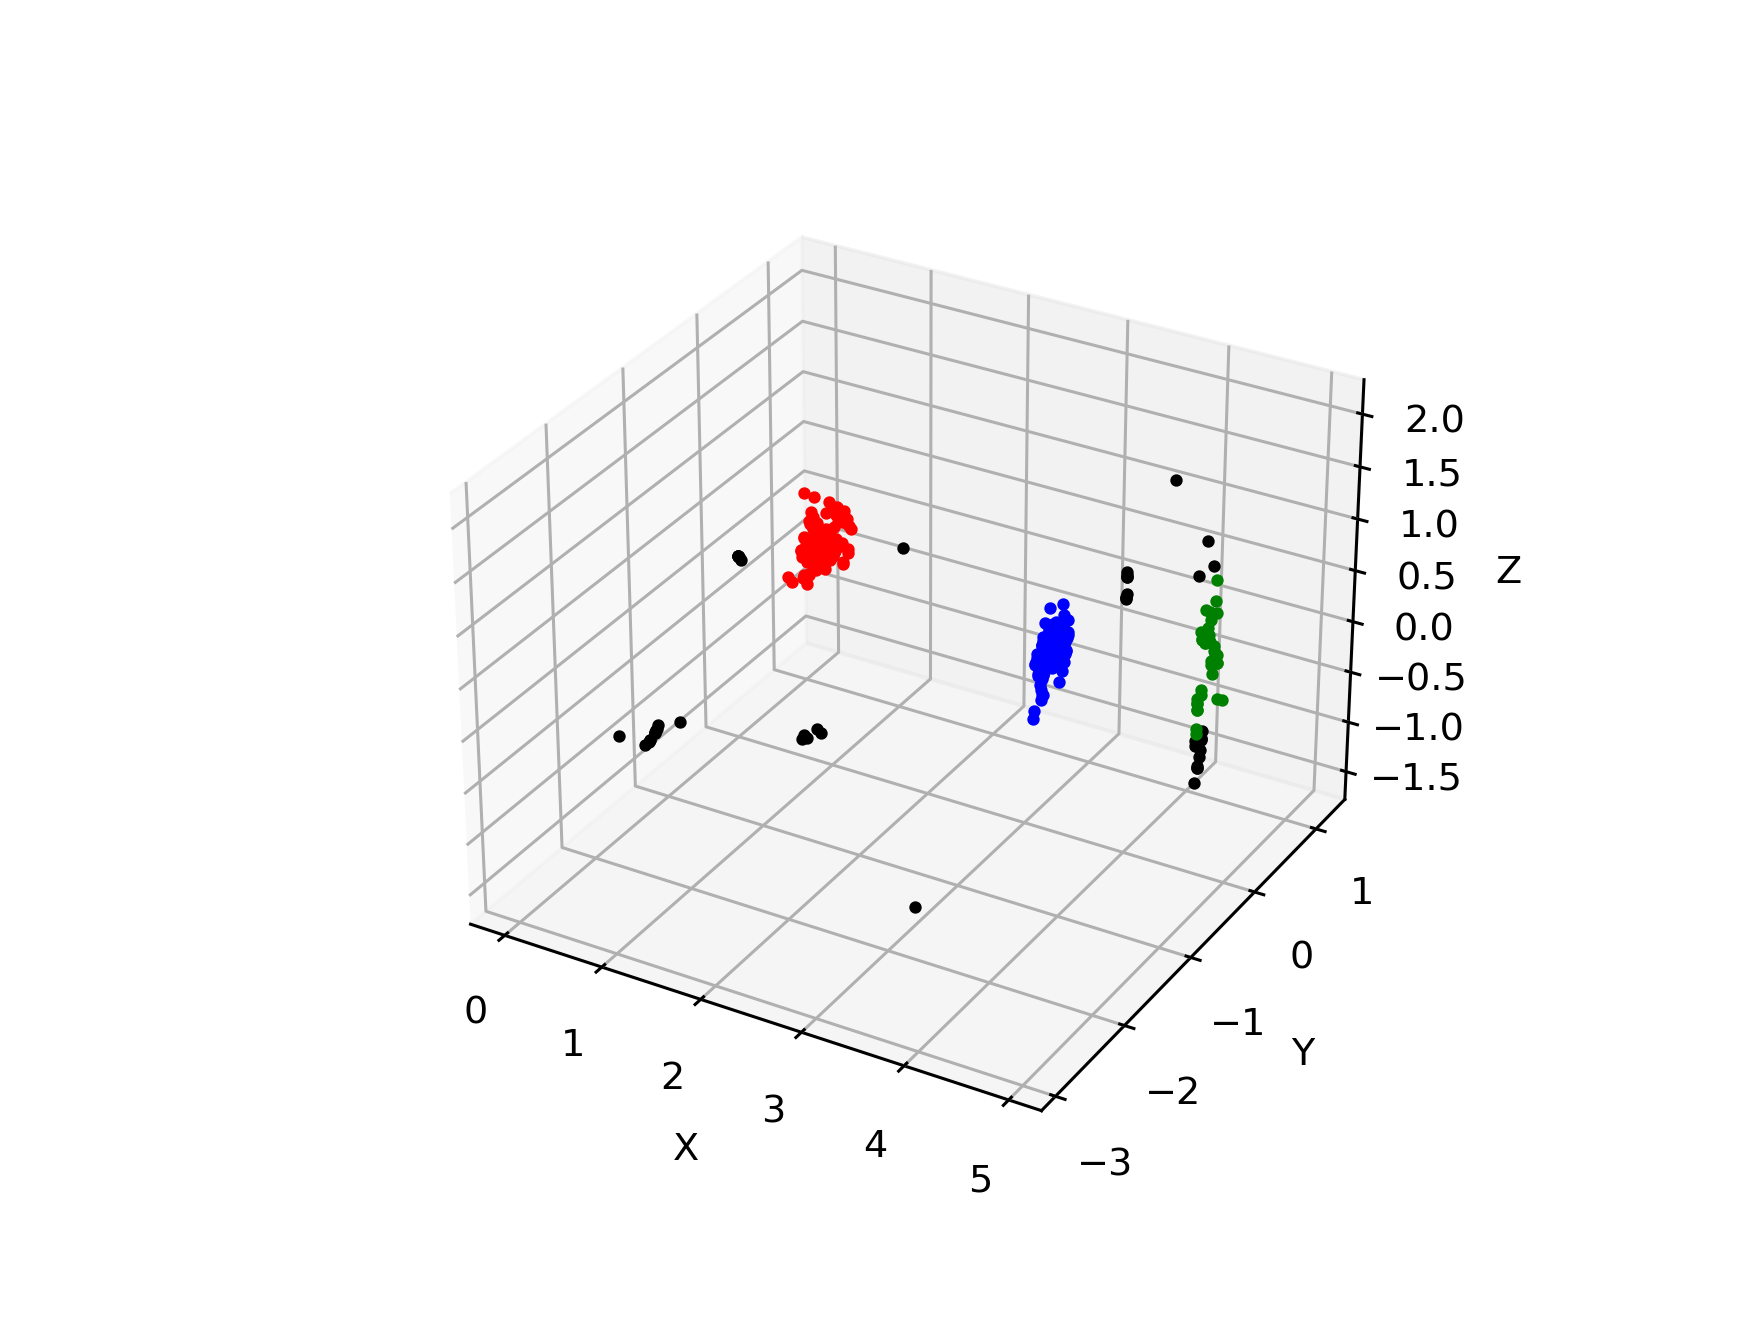

In [204]:
# Clustering frame_num = 10~14
startFrame = 10
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

ModelCluster(datalist, dbscan, sample_weight=False)
ModelCluster(datalist, dbscan, sample_weight=True)

<IPython.core.display.Javascript object>


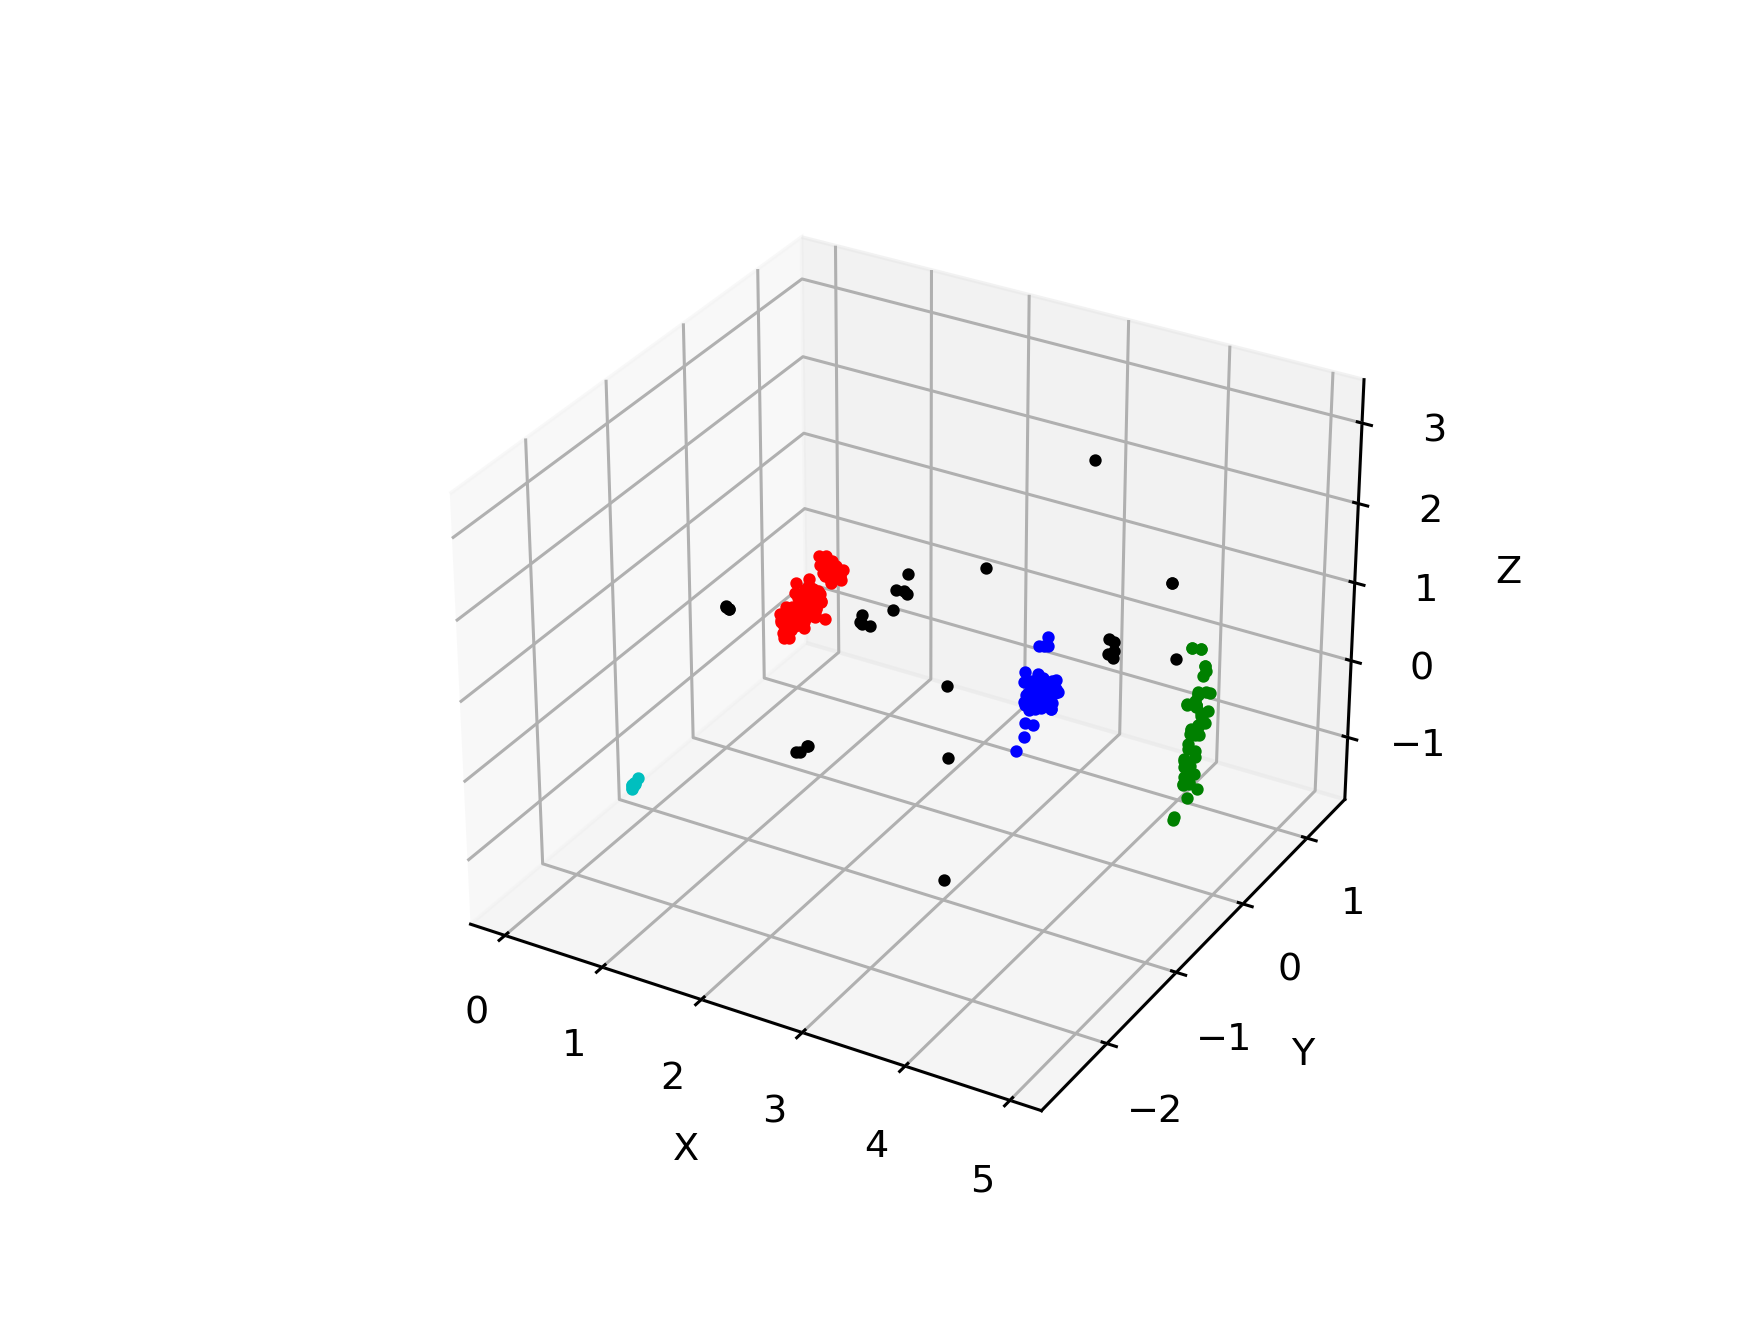

<IPython.core.display.Javascript object>


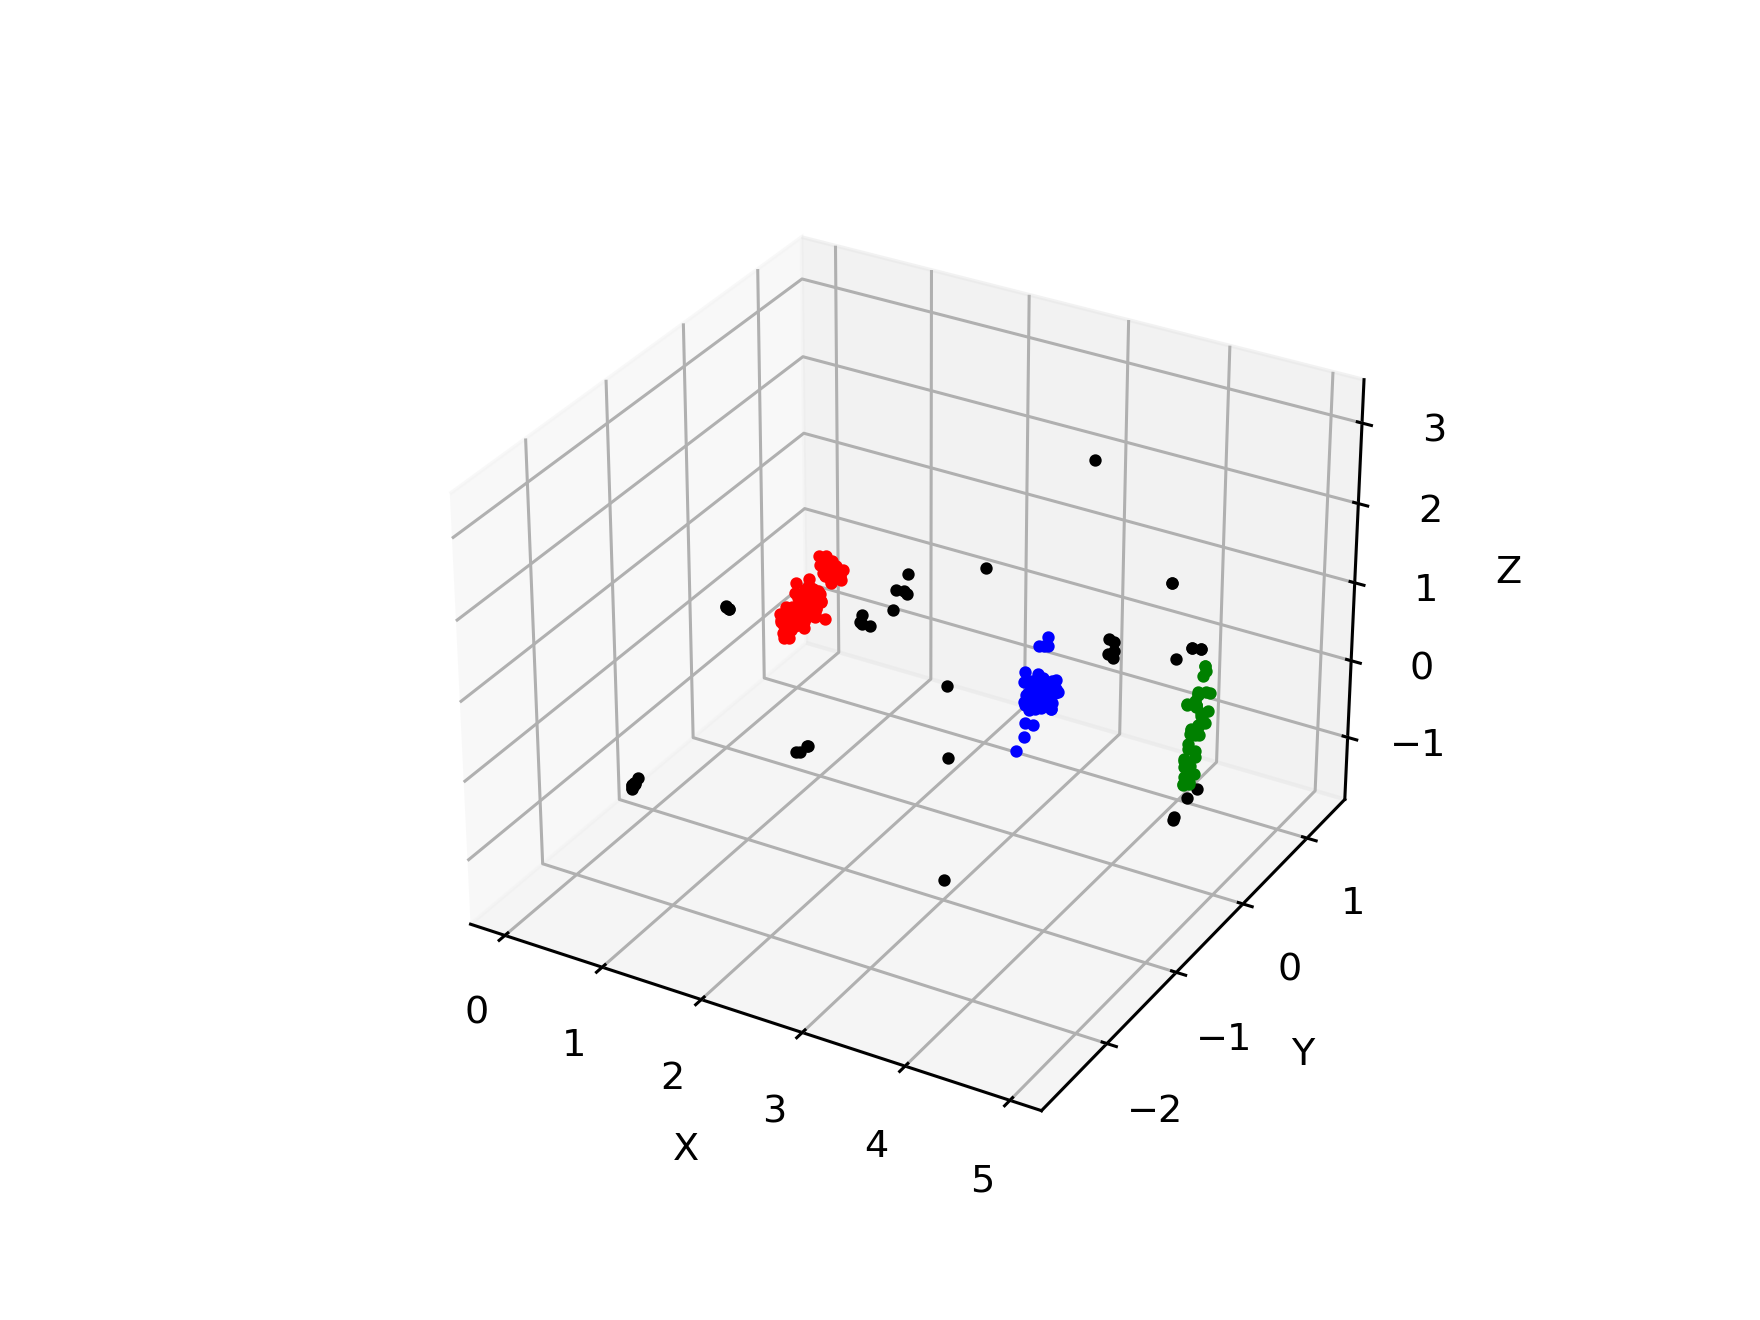

In [205]:
# Clustering frame_num = 15~19
startFrame = 15
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

ModelCluster(datalist, dbscan, sample_weight=False)
ModelCluster(datalist, dbscan, sample_weight=True)

## Change DBSCAN eps, min_samples [TODO]

# Estimate boundary for each cluster (extension, orientation)

In [26]:
# Clustering frame_num = 0~4
startFrame = 0
dbscan = DBSCAN(eps=0.4, min_samples=10)
datalist = data[(data.frame_num>=startFrame)&(data.frame_num<startFrame+WINDOW)]

clustering = ModelCluster(datalist, dbscan, sample_weight=True, show_plot=False, return_cluster=True)
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1, -1,
       -1,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1, -1,  2,  2,  2,  2, -1,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  2,  2,  2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1, -1, -1,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1, -1,  2,  2,  2,  2, -1,  0,  0,  0, -1,  0,
        0,  0,  0,  1,  1,  1,  2,  2, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  2,  2,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1, -1,  2,
        2,  2,  2, -1,  0,  0,  0,  1,  1,  1,  2,  2, -1,  0,  0,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,  1,  1,  1,  1,  1,
       -1, -1,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,
        1,  1,  1,  1,  1, -1,  2,  2,  2,  2, -1,  0,  0,  0,  0,  0,  1,
        1,  1, -1,  2,  2

In [21]:
# Number of points in each cluster
def ClusterAnalysis(labels):
    print('Total:', len(labels), 'points,', len(np.unique(labels))-1, 'clusters')
    for i in range(np.max(np.unique(labels))+1):
        print('Cluster', i, ':', np.sum(labels==i), 'points')
    print('Noise:', np.sum(labels==-1), 'points')

In [27]:
ClusterAnalysis(clustering.labels_)

Total: 282 points, 3 clusters
Cluster 0 : 116 points
Cluster 1 : 79 points
Cluster 2 : 48 points
Noise: 39 points


In [22]:
# Weighted centroid position of current cluster
def ClusterCenter(clusterlist):
    return np.average(clusterlist[['x','y','z']], axis=0, weights=Weight(clusterlist))

In [28]:
# Weighted centroid position of 0-th cluster at 0-th timeStep

clusterlist = datalist[clustering.labels_==0]
cluster_center = ClusterCenter(clusterlist)
print(cluster_center)

[0.56687295 0.45225677 0.13095793]


In [23]:
# Estimate extension of the cluster
def ClusterExtension(clusterlist, orientation = True):
    cluster_pt_weight = Weight(clusterlist)
    cluster_center = ClusterCenter(clusterlist)

    if orientation:
        cluster_cov = CalcCovariance(clusterlist, cluster_center, cluster_pt_weight, orientation=orientation)
        # cluster_npcov = np.cov(np.array(clusterlist[['x','y','z']]), rowvar=False, aweights=cluster_pt_weight) # Or use default weighted cov function from numpy (slightly difference in extension, same in orientation)

        cluster_extension, cluster_orientation = np.linalg.eig(cluster_cov) # Use eigenvalue, eigenvector for estimating extension, orientation
        cluster_extension = np.sqrt(cluster_extension)*6 # Gaussian 3-sigma rule
        cluster_orientation = cluster_orientation.T
        
        cluster_extension, cluster_orientation = ShiftAxis(cluster_extension, cluster_orientation)

    else:
        # Orientation set default to along axes
        ## Method 1: box constraint
        # cluster_extension = np.array([np.max(clusterlist.x) - np.min(clusterlist.x), np.max(clusterlist.y) - np.min(clusterlist.y), np.max(clusterlist.z) - np.min(clusterlist.z)])
        
        ## Method 2: assume points in each axis is normal distribution
        cluster_cov = CalcCovariance(clusterlist, cluster_center, cluster_pt_weight, orientation=orientation)
        cluster_extension = np.sqrt(cluster_cov)*6 # Gaussian 3-sigma rule
        cluster_orientation = np.identity(3)

    return cluster_extension, cluster_orientation

In [24]:
# Calculate covariance of centroid function of current cluster (clusterlist: list of points), with two methods
# Method 1 (orientation=True): Estimating arbitrary orientation
# Method 2 (orientation=False): Set orientation to defuault axes-oriented
def CalcCovariance(clusterlist, cluster_center, cluster_pt_weight, orientation=True):
    if orientation:
        cluster_cov = np.zeros((3,3))
        for i in range(len(clusterlist.index)):
            cluster_cov += cluster_pt_weight[i]*np.dot(HorToVer(np.array(clusterlist[['x','y','z']])[i]-cluster_center), VerToHor(np.array(clusterlist[['x','y','z']])[i]-cluster_center))
    else:
        cluster_cov = np.zeros(3)
        for i in range(len(clusterlist.index)):
            cluster_cov[0] += cluster_pt_weight[i]*np.dot(np.array(clusterlist.x)[i]-cluster_center[0], np.array(clusterlist.x)[i]-cluster_center[0])
            cluster_cov[1] += cluster_pt_weight[i]*np.dot(np.array(clusterlist.y)[i]-cluster_center[1], np.array(clusterlist.y)[i]-cluster_center[1])
            cluster_cov[2] += cluster_pt_weight[i]*np.dot(np.array(clusterlist.z)[i]-cluster_center[2], np.array(clusterlist.z)[i]-cluster_center[2])

    cluster_cov = cluster_cov/np.sum(cluster_pt_weight)
    return cluster_cov            


In [25]:
from scipy.optimize import linear_sum_assignment

# Shift (l,w,h) order in arbitrary orientations so they align (as close as possible) with 3 axes
def ShiftAxis(cluster_extension, cluster_orientation):
    shift_index = np.zeros((3,3))
    for axis in range(3):
        for idx in range(3):
            shift_index[axis, idx] = VectorAngle(cluster_orientation[idx], np.identity(3)[axis])
    shift_index = linear_sum_assignment(shift_index, maximize=True)[1] # Hungarian Algorithm, column index
    
    cluster_orientation = cluster_orientation[shift_index]
    cluster_extension = cluster_extension[shift_index]
    
    for idx in range(3):
        if np.dot(cluster_orientation[idx], np.identity(3)[idx])<0:
            cluster_orientation[idx] = -cluster_orientation[idx]
    
    return cluster_extension, cluster_orientation

In [29]:
# Esimate extension of 0-th cluster at 0-th timeStep

# With orientation
cluster_extension, cluster_orientation = ClusterExtension(clusterlist)
print('With orientation estimation:')
print('length:', cluster_extension[0])
print('width:', cluster_extension[1])
print('height:', cluster_extension[2])
print('orientation:', cluster_orientation[np.argmax(cluster_extension)])

# Without orientation
cluster_extension, cluster_orientation = ClusterExtension(clusterlist, orientation=False)
print('\nWithout orientation estimation:')
print('length:', cluster_extension[0])
print('width:', cluster_extension[1])
print('height:', cluster_extension[2])
print('orientation:', cluster_orientation[np.argmax(cluster_extension)])

With orientation estimation:
length: 0.422100435303007
width: 0.7945291928128605
height: 0.7518883681918821
orientation: [ 0.08439314  0.87876826 -0.46972773]

Without orientation estimation:
length: 0.4282238543972365
width: 0.7821356392089456
height: 0.7613604312948521
orientation: [0. 1. 0.]


In [30]:
# ref: http://kylebarbary.com/nestle/examples/plot_ellipsoids.html

# Plot the 3-d Ellipsoid on the Axes3D ax.
def PlotEllipsoid(ax, center, orientation, color='dodgerblue', npoints=100):
    # Set points on unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, npoints)
    v = np.linspace(0.0, np.pi, npoints)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Transform points to ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j], y[i,j], z[i,j] = center + np.dot(orientation, [x[i,j], y[i,j], z[i,j]])

    ax.plot_wireframe(x, y, z,  rstride=10, cstride=10, color=color, alpha=0.2, linewidth=1)


In [31]:
def PlotArrow(ax, center, orientation, extension=np.ones(3)/2):
    # center: array 1x3
    # orientation: matrix 3x3
    # extension: array 1x3
    ax.quiver(center[0], center[1], center[2], orientation[0][0], orientation[0][1], orientation[0][2], length=extension[0], color='tab:blue', normalize=True)
    ax.quiver(center[0], center[1], center[2], orientation[1][0], orientation[1][1], orientation[1][2], length=extension[1], color='tab:orange', normalize=True)
    ax.quiver(center[0], center[1], center[2], orientation[2][0], orientation[2][1], orientation[2][2], length=extension[2], color='tab:green', normalize=True)


In [32]:
def PlotClusterEllipsoid(ax, clusterlist, orientation=True,  plot_arrow=True, color='dodgerblue'):
    cluster_center = ClusterCenter(clusterlist)
    cluster_extension, cluster_orientation = ClusterExtension(clusterlist, orientation=orientation)
    print('Center=', cluster_center, '\tL=', cluster_extension[0], '\tW=', cluster_extension[1], '\tH=', cluster_extension[2], '\tDirection=', cluster_orientation[np.argmax(cluster_extension)])

    # Plot center
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], color='r', marker='.')

    # Plot ellipsoid
    PlotEllipsoid(ax, cluster_center, (cluster_orientation * HorToVer(cluster_extension)/2).T, color=color)
    
    # Plot orientation arrow
    if plot_arrow:
        PlotArrow(ax, cluster_center, cluster_orientation, cluster_extension/2)
        

<IPython.core.display.Javascript object>


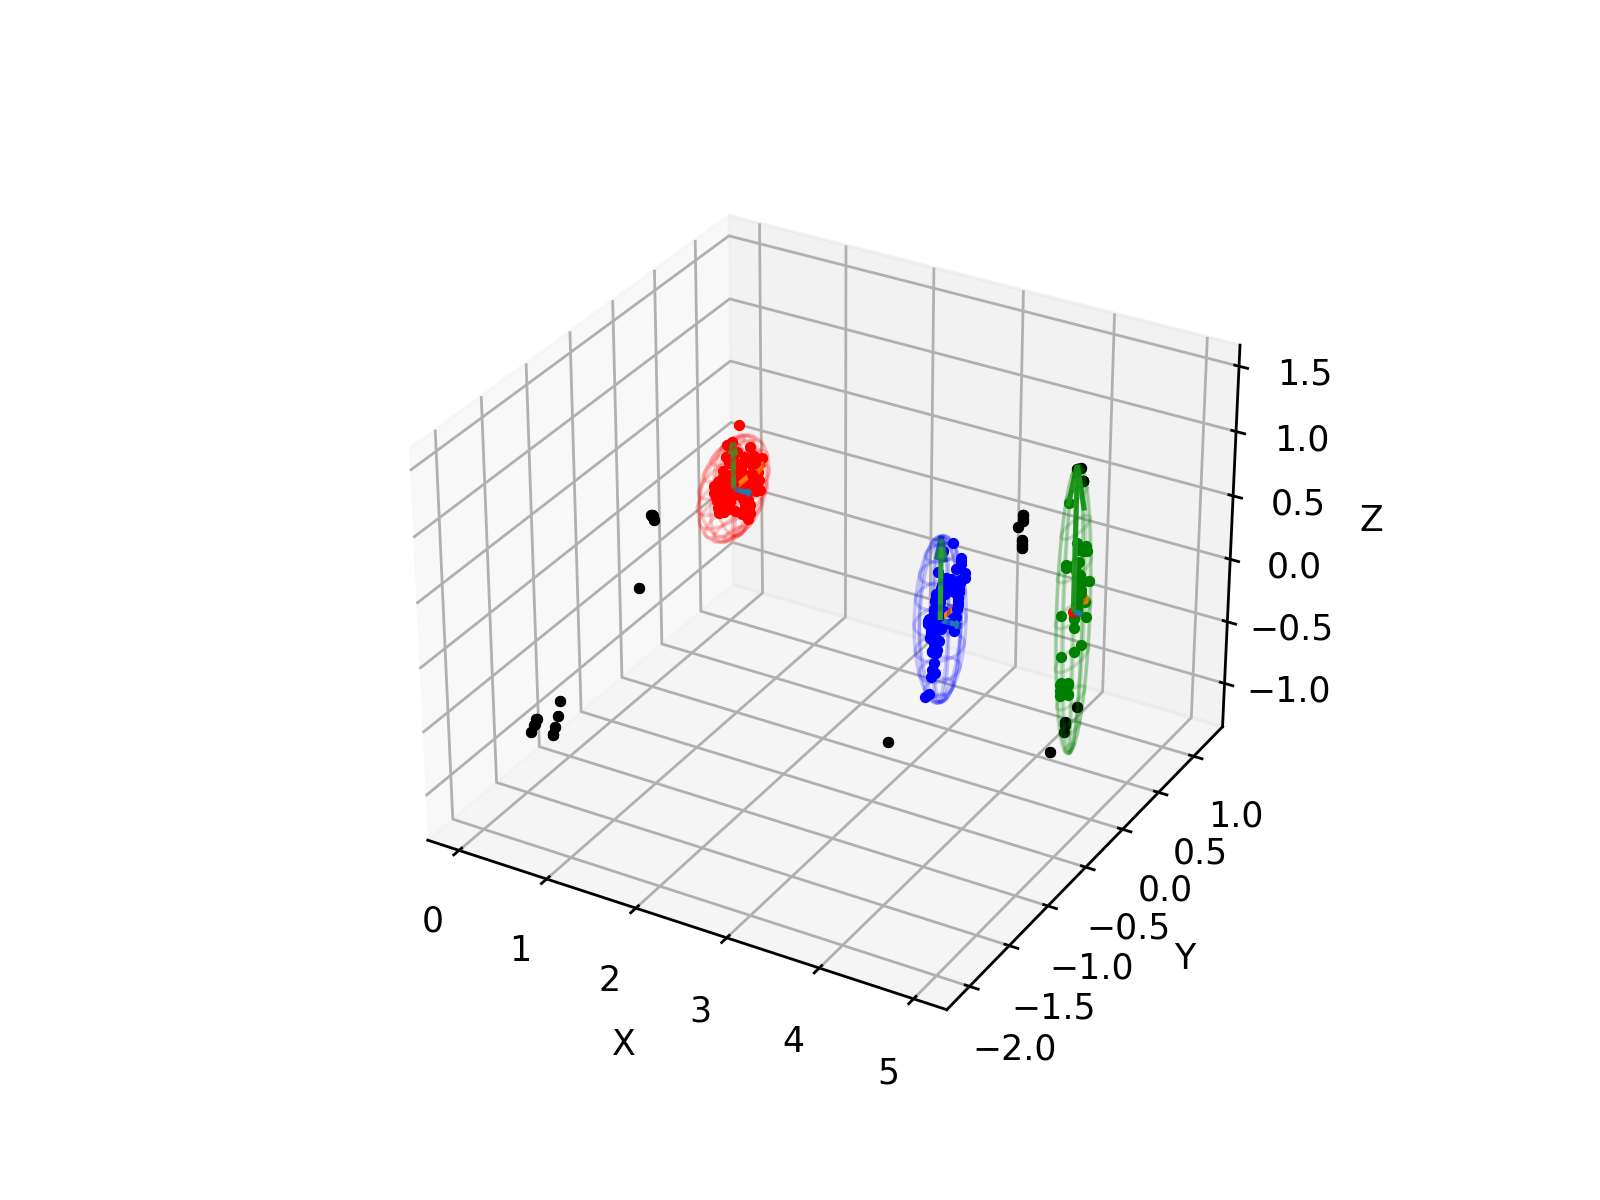

Center= [0.56687295 0.45225677 0.13095793] 	L= 0.4282238543972365 	W= 0.7821356392089456 	H= 0.7613604312948521 	Direction= [0. 1. 0.]
Center= [ 2.88128528  0.51303842 -0.49494222] 	L= 0.4618542197069611 	W= 0.425554289812297 	H= 1.330748432248082 	Direction= [0. 0. 1.]
Center= [ 4.88946754 -0.17889106  0.36376165] 	L= 0.19055439718205736 	W= 0.4081591967203814 	H= 2.208091211067745 	Direction= [0. 0. 1.]


In [891]:
# Estimate extension of all clusters at 0-th timeStep (default orientation on axes)

fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

PlotData(ax, datalist, color=GetColors(clustering.labels_))

for i in range(np.max(np.unique(clustering.labels_))+1):
    PlotClusterEllipsoid(ax, datalist[clustering.labels_==i], orientation=False, plot_arrow=True, color=GetColors([i]))
PlotData(ax, datalist[clustering.labels_==-1], color='k')

plt.show()

<IPython.core.display.Javascript object>


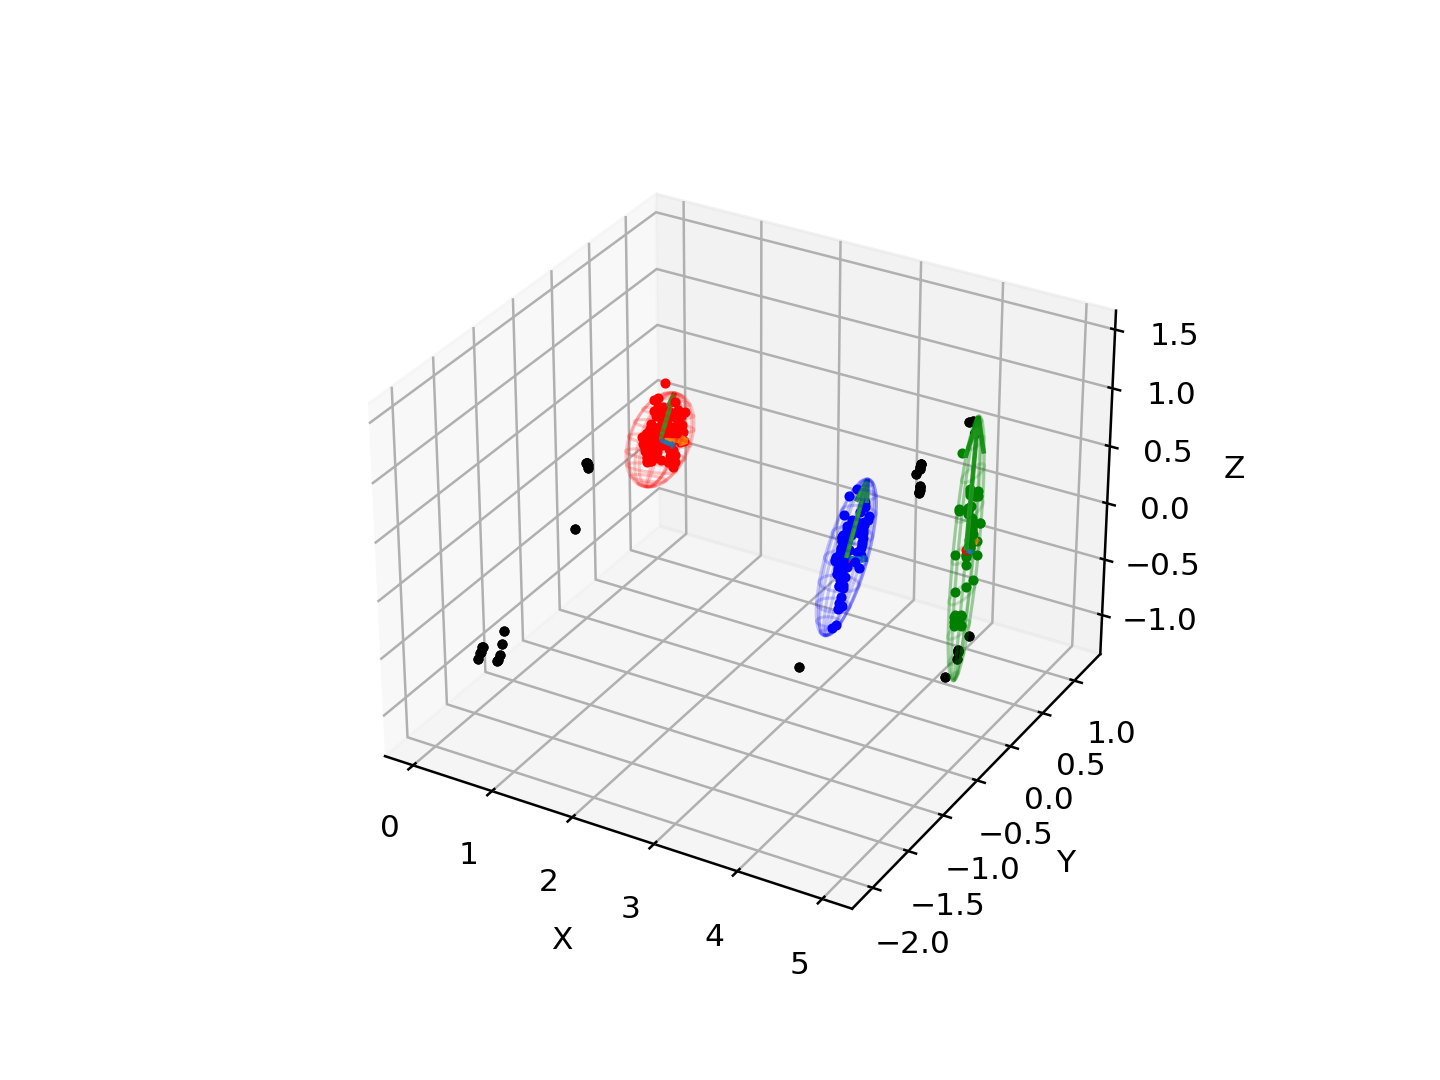

Center= [0.56687295 0.45225677 0.13095793] 	L= 0.422100435303007 	W= 0.7945291928128605 	H= 0.7518883681918821 	Direction= [ 0.08439314  0.87876826 -0.46972773]
Center= [ 2.88128528  0.51303842 -0.49494222] 	L= 0.4254454497802436 	W= 0.27673762674613045 	H= 1.3811986167722983 	Direction= [0.21840873 0.1774787  0.95958269]
Center= [ 4.88946754 -0.17889106  0.36376165] 	L= 0.15848996012872352 	W= 0.39165227668122804 	H= 2.2136081702180888 	Direction= [0.04673154 0.05373684 0.99746103]


In [33]:
# Estimate extension of all clusters at 0-th timeStep (arbitrary orientation)

fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

PlotData(ax, datalist, color=GetColors(clustering.labels_))

for i in range(np.max(np.unique(clustering.labels_))+1):
    PlotClusterEllipsoid(ax, datalist[clustering.labels_==i], orientation=True, plot_arrow=True, color=GetColors([i]))
PlotData(ax, datalist[clustering.labels_==-1], color='k')

plt.show()

# Cluster-based Observation state

Observation state of frame_num = $k$, cluster_num = $n$: $z(k,n) = [cluster\_center, cluster\_extension, cluster\_orientation]$

All info of frame_num = $k$, cluster\_num = $n$: $Z(k,n) = [z(k,n), z\_cov(k,n), \{points\_index\}]$

In [34]:
def InitObservationDataFrame():
    return pd.DataFrame(columns=['frame_num','cluster_num','track_num','x','y','z','l','w','h','ori_x','ori_y','ori_z','cov','pts'])

In [35]:
# Output combined observation estimations to Z(k,n)
def GenerateObservationStates(data, startFrame, endFrame, orientation=True):
    observation_states = InitObservationDataFrame()

    for frame_num in range(startFrame, endFrame+1):
        dbscan = DBSCAN(eps=0.4, min_samples=10)
        datalist = data[(data.frame_num>=frame_num)&(data.frame_num<frame_num+WINDOW)]

        clustering = ModelCluster(datalist, dbscan, sample_weight=True, show_plot=False, return_cluster=True)

        for cluster_num in range(-1, np.max(np.unique(clustering.labels_))+1):
            clusterlist = datalist[clustering.labels_==cluster_num]
            
            observation_state = InitObservationDataFrame()
            observation_state.at[0,'frame_num'] = frame_num
            observation_state.at[0,'cluster_num'] = cluster_num
            observation_state.at[0,'track_num'] = cluster_num # Initial track_num, before mapping to tracks
            observation_state.at[0,'pts'] = list(clusterlist.index)
            
            if cluster_num != -1:
                cluster_center = ClusterCenter(clusterlist)
                cluster_extension, cluster_orientation = ClusterExtension(clusterlist, orientation=orientation)
                cluster_pt_weight = Weight(clusterlist)
                cluster_cov = CalcCovariance(clusterlist, cluster_center, cluster_pt_weight, orientation=orientation)

                observation_state.at[0,['x','y','z']] = cluster_center
                observation_state.at[0,['l','w','h']] = cluster_extension
                observation_state.at[0,'ori_x'] = cluster_orientation[0]
                observation_state.at[0,'ori_y'] = cluster_orientation[1]
                observation_state.at[0,'ori_z'] = cluster_orientation[2]
                observation_state.at[0,'cov'] = cluster_cov

            observation_states = observation_states.append(observation_state, ignore_index=True)
        
        print('Frame ', frame_num, 'is done.')

    return observation_states

In [36]:
observation_states = GenerateObservationStates(data, 0, 10, orientation=True)
observation_states

Frame  0 is done.
Frame  1 is done.
Frame  2 is done.
Frame  3 is done.
Frame  4 is done.
Frame  5 is done.
Frame  6 is done.
Frame  7 is done.
Frame  8 is done.
Frame  9 is done.
Frame  10 is done.


frame_num cluster_num track_num         x         y          z         l  \
0          0          -1        -1       NaN       NaN        NaN       NaN   
1          0           0         0  0.566873  0.452257   0.130958    0.4221   
2          0           1         1   2.88129  0.513038  -0.494942  0.425445   
3          0           2         2   4.88947 -0.178891   0.363762   0.15849   
4          1          -1        -1       NaN       NaN        NaN       NaN   
5          1           0         0  0.559646  0.456485   0.107228  0.407342   
6          1           1         1   2.88192  0.516161  -0.489714  0.439938   
7          1           2         2   4.88924 -0.177891   0.355778  0.161629   
8          2          -1        -1       NaN       NaN        NaN       NaN   
9          2           0         0  0.555775  0.454319  0.0863962   0.29823   
10         2           1         1   2.87995  0.510225  -0.499422  0.424638   
11         2           2         2   4.89419 -0.191431   0.383608    0.1622   
12         3          -1        -1       NaN       NaN        NaN       NaN   
13         3           0         0  0.554477    0.4439  0.0857675  0.249978   
14         3           1         1   2.87007  0.515097  -0.540504  0.286128   
15         3           2         2   4.89185 -0.192184   0.384735  0.168606   
16         4          -1        -1       NaN       NaN        NaN       NaN   
17         4           0         0  0.544728  0.432342  0.0949541   0.25924   
18         4           1         1   2.87576  0.523935   -0.51554  0.276284   
19         4           2         2   4.89039 -0.191872   0.399024  0.174734   
20         5          -1        -1       NaN       NaN        NaN       NaN   
21         5           0         0  0.542119  0.427622   0.092702  0.263095   
22         5           1         1   2.87685  0.523728  -0.504436  0.289483   
23         5           2         2   4.89146 -0.188291   0.415528  0.175844   
24         6          -1        -1       NaN       NaN        NaN       NaN   
25         6           0         0  0.542781  0.420366  0.0822401  0.259217   
26         6           1         1   2.86792  0.516473  -0.551583   0.44425   
27         6           2         2   4.89278   -0.1987   0.430692  0.177756   
28         7          -1        -1       NaN       NaN        NaN       NaN   
29         7           0         0  0.536959  0.427969  0.0576652  0.289617   
30         7           1         1   2.87431  0.515465  -0.527866  0.298711   
31         7           2         2   4.89578 -0.188382   0.541281  0.174309   
32         8          -1        -1       NaN       NaN        NaN       NaN   
33         8           0         0  0.544756  0.436823  0.0410999  0.402999   
34         8           1         1   2.87989  0.512967  -0.505397  0.436674   
35         8           2         2   4.89701 -0.194171   0.524973  0.163937   
36         9          -1        -1       NaN       NaN        NaN       NaN   
37         9           0         0  0.559375  0.449846  0.0336185  0.505479   
38         9           1         1   2.88199  0.510033  -0.495037  0.438723   
39         9           2         2   4.89778 -0.204556   0.479537   0.15954   
40        10          -1        -1       NaN       NaN        NaN       NaN   
41        10           0         0  0.561742  0.485779  0.0439579  0.581861   
42        10           1         1   2.88723  0.505963  -0.477347  0.425953   
43        10           2         2   4.89788 -0.210143   0.468908  0.159025   

           w         h                                              ori_x  \
0        NaN       NaN                                                NaN   
1   0.794529  0.751888  [0.9938633377363293, -0.10806609548316558, -0....   
2   0.276738    1.3812  [0.6876513464024218, 0.669717547943948, -0.280...   
3   0.391652   2.21361  [0.9967752491095346, 0.0627005982260056, -0.05...   
4        NaN       NaN                                        

# Track-based estimated state

Estimated state of frame_num = $k$, track_num = $t$: $s(k,t) = [position, velocity, extension, orientation]$

All info of frame_num = $k$, track_num = $t$: $S(k,t) = [s(k,t), s\_cov(k,t), Z(k,t)]$

Error covariance of $s(k,t)$: $s\_cov(k,t) = P(k,t)$ in KF updates (later)

In [37]:
def InitEstimateDataFrame():
    return pd.DataFrame(columns=['frame_num','track_num','x','y','z','vx','vy','vz','l','w','h','ori_x','ori_y','ori_z','cov','pts'])

In [38]:
# Initialize S(0,t) from Z(0,n)
# Initial data association between n and t: n=t
def InitEstimateState(observation_states, startFrame):
    estimate_states = InitEstimateDataFrame()
    
    init_observation_states = observation_states[(observation_states.frame_num==startFrame)&(observation_states.cluster_num!=-1)]
    for i in list(init_observation_states.index):
        estimate_states.at[i,'frame_num'] = init_observation_states.loc[i,'frame_num']
        estimate_states.at[i,'track_num'] = init_observation_states.loc[i,'track_num']
        estimate_states.at[i,['x','y','z']] = init_observation_states.loc[i,['x','y','z']]
        estimate_states.at[i,['vx','vy','vz']] = [0, 0, 0]
        estimate_states.at[i,['l','w','h']] = init_observation_states.loc[i,['l','w','h']]
        estimate_states.at[i,'ori_x'] = init_observation_states.loc[i,'ori_x']
        estimate_states.at[i,'ori_y'] = init_observation_states.loc[i,'ori_y']
        estimate_states.at[i,'ori_z'] = init_observation_states.loc[i,'ori_z']
        estimate_states.at[i,'cov'] = np.zeros((9,9))
        estimate_states.at[i,'pts'] = init_observation_states.loc[i,'pts']

    return estimate_states

In [39]:
estimate_states = InitEstimateState(observation_states, 0)
estimate_states

frame_num track_num         x         y         z vx vy vz         l  \
1         0         0  0.566873  0.452257  0.130958  0  0  0    0.4221   
2         0         1   2.88129  0.513038 -0.494942  0  0  0  0.425445   
3         0         2   4.88947 -0.178891  0.363762  0  0  0   0.15849   

          w         h                                              ori_x  \
1  0.794529  0.751888  [0.9938633377363293, -0.10806609548316558, -0....   
2  0.276738    1.3812  [0.6876513464024218, 0.669717547943948, -0.280...   
3  0.391652   2.21361  [0.9967752491095346, 0.0627005982260056, -0.05...   

                                               ori_y  \
1  [0.08439314476724513, 0.8787682611187487, -0.4...   
2  [-0.6924111868086408, 0.7210961923677758, 0.02...   
3  [-0.06523240027478272, 0.9965846613521786, -0....   

                                               ori_z  \
1  [0.07150848215350519, 0.46485273179508585, 0.8...   
2  [0.21840873190691448, 0.17747869542184794, 0.9...   
3  [0.04673153878287673, 0.053736837827179966, 0....   

                                                 cov  \
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   

                                                 pts  
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 21, 22, 23, 24, 25...  
2  [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 3...  
3  [18, 19, 20, 37, 38, 39, 40, 52, 53, 54, 73, 7...

# Kalman Filter algorithm

Estimated state: $s(k+1) = F * s(k) + \mu$, process noise $\mu \sim \mathcal{N}(0, Q)$

Observation state: $z(k) = H * s(k) + r(k)$, measurement noise $r(k) \sim \mathcal{N}(0, R(k))$


**(Without orientation)**

$s(k) = [x, y, z, v_x, v_y, v_z, l, w, h]_k^T$

$z(k) = [\mu_x, \mu_y, \mu_z, \tilde{l}, \tilde{w}, \tilde{h}]_k^T$

$F = blkdiag([[1,\Delta t],[0,1]] ⊗ I_3, I_3)$

$H = [[I_3, O_{3x3}, O_{3x3}], [O_{3x3}, O_{3x3}, I_3]]$

$Q = blkdiag(g * g^T ⊗ diag(\sigma_{ax}^2, \sigma_{ay}^2, \sigma_{ax}^2), diag(\sigma_l^2, \sigma_w^2, \sigma_h^2))$

$R(k) = blkdiag(R'(k), diag(\sigma_{\tilde{l}}^2, \sigma_{\tilde{w}}^2, \sigma_{\tilde{h}}^2))$

$R'(k) = J(k) * R_{pol} * J(k)^T$, $R_{pol} = diag(\sigma_R^2, \sigma_\theta^2, \sigma_\phi^2)$


In [40]:
# Define global parameters for KF algorithm
FPS = 10
DELTA_T = WINDOW/FPS
sigma_R = 0.03
sigma_theta = np.pi/24
sigma_phi = np.pi/24
sigma_ax = 8
sigma_ay = 8
sigma_az = 0
sigma_l = 0.001
sigma_w = 0.001
sigma_h = 0.001

In [41]:
from scipy.linalg import block_diag

KF_F = block_diag(np.kron(np.matrix([[1,DELTA_T],[0,1]]), np.identity(3)), np.identity(3))
KF_H = np.concatenate((np.concatenate((np.identity(3),np.zeros((3,6))), axis=1), np.concatenate((np.zeros((3,6)), np.identity(3)), axis=1)))
KF_g = np.array([[DELTA_T**2/2], [DELTA_T]])
KF_Q = block_diag(np.kron(KF_g*KF_g.T, np.diag([sigma_ax**2, sigma_ay**2, sigma_az**2])), np.diag([sigma_l**2, sigma_w**2, sigma_h**2]))


In [42]:
# KF_R depending on (x,y,z)
def CalcR(x, y, z):
    R, theta, phi = CarToSph(x, y, z)
    
    # Jacobian matrix
    KF_J = np.matrix([[np.cos(theta)*np.sin(phi), -R*np.sin(theta)*np.sin(phi), R*np.cos(theta)*np.cos(phi)], 
                      [np.sin(theta)*np.sin(phi), R*np.cos(theta)*np.sin(phi), R*np.sin(theta)*np.cos(phi)], 
                      [np.cos(phi), 0, -R*np.sin(phi)]])

    KF_R_pol = np.diag([sigma_R**2, sigma_theta**2, sigma_phi**2])
    return KF_J.dot(KF_R_pol).dot(KF_J.T)

In [43]:
# KF_R = block_diag(CalcR(x, y, z), observation_state_cov)
def KF_R(position, observation_cov):
    return block_diag(CalcR(position[0], position[1], position[2]), observation_cov)

**Step 1: time update (predict)**

$s(k+1) = F * s(k)$

$P(k+1) = F * P(k) * F + Q$

**Step 2: measurement update (correct)**

$K(k) = H * P(k+1) * H^T + R(k)$

$s(k+1) = s(k+1) + P(k+1) * H^T * K(k)^{-1} * (z(k+1)-H * s(k+1))$

$P(k+1) = P(k+1) - P(k+1) * H^T * K(k)^{-1} * H * P(k+1)$

In [223]:
# Kalman filter updating
def KF_Update(frame_num, observation_states, estimate_states):
    if frame_num == 0:
        estimate_states = InitEstimateState(observation_states, frame_num)
    else:
        for track_num in np.unique(observation_states.track_num[(observation_states.frame_num==frame_num)&(observation_states.cluster_num!=-1)]):
            # s_k (of track_num) not exist: initialize the new track
            if len(estimate_states[(estimate_states.frame_num<frame_num)&(estimate_states.frame_num>=frame_num-DA_TRACKGAP)&(estimate_states.track_num==track_num)]) == 0:
                estimate_states = estimate_states.append(InitEstimateState(observation_states[observation_states.track_num==track_num], frame_num), ignore_index=True)
            
            # s_k (of track_num) exist
            else:
                z_state = np.array(observation_states[(observation_states.frame_num==frame_num)&(observation_states.track_num==track_num)].iloc[0][['x','y','z','l','w','h']])
                z_cov = observation_states[(observation_states.frame_num==frame_num)&(observation_states.track_num==track_num)]['cov'].to_numpy()[0]

                estimate_track_idx = np.max(estimate_states.index[(estimate_states.frame_num<frame_num)&(estimate_states.frame_num>=frame_num-DA_TRACKGAP)&(estimate_states.track_num==track_num)])
                s_state = np.array(estimate_states.loc[estimate_track_idx][['x','y','z','vx','vy','vz','l','w','h']])
                s_cov = estimate_states.loc[estimate_track_idx]['cov']

                # Time update (predict)
                s_state = KF_F.dot(s_state)
                s_cov = KF_F.dot(s_cov).dot(KF_F.T) + KF_Q

                # Measurement update (correct)
                KF_K = KF_H.dot(s_cov).dot(KF_H.T) + KF_R(z_state[:3], z_cov)
                s_state = s_state + s_cov.dot(KF_H.T).dot(np.linalg.inv(KF_K)).dot(z_state-KF_H.dot(s_state))
                s_cov = s_cov - s_cov.dot(KF_H.T).dot(np.linalg.inv(KF_K)).dot(KF_H).dot(s_cov)

                estimate_state = InitEstimateDataFrame()
                estimate_state.at[0,'frame_num'] = frame_num
                estimate_state.at[0,'track_num'] = track_num
                estimate_state.at[0,['x','y','z']] = s_state[:3]
                estimate_state.at[0,['vx','vy','vz']] = s_state[3:6]
                estimate_state.at[0,['l','w','h']] = s_state[6:]
                estimate_state.at[0,'ori_x'] = observation_states[(observation_states.frame_num==frame_num)&(observation_states.track_num==track_num)]['ori_x'].to_numpy()[0]
                estimate_state.at[0,'ori_y'] = observation_states[(observation_states.frame_num==frame_num)&(observation_states.track_num==track_num)]['ori_y'].to_numpy()[0]
                estimate_state.at[0,'ori_z'] = observation_states[(observation_states.frame_num==frame_num)&(observation_states.track_num==track_num)]['ori_z'].to_numpy()[0]
                estimate_state.at[0,'cov'] = s_cov
                estimate_state.at[0,'pts'] = observation_states[(observation_states.frame_num==frame_num)&(observation_states.track_num==track_num)]['pts'].to_numpy()[0]

                estimate_states = estimate_states.append(estimate_state, ignore_index=True)
    return estimate_states

# Data association (n ↔ t)

**Method:**

Use Hungarian Algorithm on score matrix $\Gamma(n,t)$ to map $n ↔ t$ with max outcome

Score matrix (association probability) $\Gamma(n,t)=G(n,t)/(\Sigma_t G(n,t)+\Sigma_n G(n,t)-G(n,t)+\beta)$

Gaussian likelihood $G(n,t)=exp[-\gamma(n,t)^T * K(n,t)^{-1} * \gamma(n,t)/2]/\sqrt{det(K(n,t))}$

Measurement residue or innovation $\gamma(n,t) = z(n) - H * s(t)$

KF matrix (covariance of measurement residue $\gamma$) $K(n,t) = H * (F * P(t) * F^T) * H^T) + R(n)$


In [313]:
# Define global parameters for data association
DA_BETA = 0.01 # Bias term (beta): in score matrix equation
DA_THRESHOLD = 0.15 # low-pass filter: in score matrix, probability score<threshold is set to 0
DA_TRACK_COUNT = 30 # n (in m-n rule): for track initialization, track appear "m out of n" is intialized
DA_TRACK_APPEARANCE = 10 # m in (m-n rule): for track initialization, track appear "m out of n" is intialized

In [342]:
# Find s(k,t) from z(k,n) and s(0:k-1,t)
def ClusterTrackMapping(frame_num, observation_states, estimate_states):
    z_state, z_cov = GenerateZstates(frame_num, observation_states)
    s_state, s_cov = GenerateSstates(frame_num, estimate_states)
    
    if frame_num != 0:
        g_matrix = CalcGLikelihood(z_state, z_cov, s_state, s_cov)
        score_matrix = CalcScoreMatrix(g_matrix)

        # Use score matrix to map n↔t
        track_max = np.max(estimate_states[estimate_states.frame_num<frame_num].track_num)
        mapping_track_idx = linear_sum_assignment(score_matrix, maximize=True)[1] # Hungarian Algorithm, column index

        n_count = list(np.unique(z_state.cluster_num)) # Existing cluster number at current frame_num
        t_count = list(np.unique(s_state.track_num)) # Existing track number
        for i in range(len(n_count)):
            if score_matrix[i, mapping_track_idx[i]] >= DA_THRESHOLD: # TODO: hard threshold not good
                # i-th cluster in n_count ↔ mapping_idx[i]-th track in t_count
                z_state.at[z_state[z_state.cluster_num==n_count[i]].index[0], 'track_num'] = t_count[mapping_track_idx[i]]
            else:
                # i-th cluster in n_count ↔ new (++track_max) track
                track_max += 1
                z_state.at[z_state[z_state.cluster_num==n_count[i]].index[0], 'track_num'] = track_max

    for i in list(z_state.index):
        observation_states.track_num[i] = z_state.track_num[i]
    return observation_states # with updated track_num

In [259]:
# Generate (z_state, z_cov) from observation_states
def GenerateZstates(frame_num, observation_states):
    z_state = observation_states[(observation_states.frame_num==frame_num)&(observation_states.cluster_num!=-1)][['cluster_num','track_num','x','y','z','l','w','h']]
    z_cov = observation_states[(observation_states.frame_num==frame_num)&(observation_states.cluster_num!=-1)][['cluster_num','cov']]

    if frame_num == 0:
        for i in list(z_state.index):
            z_state.track_num[i] = z_state.cluster_num[i]

    return z_state, z_cov

# Generate (s_state, s_cov) from estimate_states
def GenerateSstates(frame_num, estimate_states):
    s_state = estimate_states[(estimate_states.frame_num<frame_num)&(estimate_states.frame_num>=frame_num-DA_TRACKGAP)][['frame_num','track_num','x','y','z','vx','vy','vz','l','w','h']]
    s_cov = estimate_states[(estimate_states.frame_num<frame_num)&(estimate_states.frame_num>=frame_num-DA_TRACKGAP)][['track_num','cov']]
    
    # Find last s_state of each existing track
    if frame_num != 0:
        for track_idx in np.unique(s_state.track_num):
            track_maxframe = np.max(s_state.frame_num[s_state.track_num==track_idx])
            remove_idx = list(s_state.index[(s_state.frame_num<track_maxframe)&(s_state.track_num==track_idx)])
            s_state = s_state.drop(remove_idx, axis=0)
            s_cov = s_cov.drop(remove_idx, axis=0)
    s_state = s_state.drop(['frame_num'], axis=1)
    
    return s_state, s_cov


In [340]:
# Calculate G(n,t)
# z_state, z_cov: cluster-based measurement
# s_state, s_cov: track-based prediction
def CalcGLikelihood(z_state, z_cov, s_state, s_cov):
    n_count = list(np.unique(z_state.cluster_num)) # Existing cluster number at current frame_num
    t_count = list(np.unique(s_state.track_num)) # Existing track number
    G = np.zeros((len(n_count), len(t_count)))
    
    for n in range(len(n_count)):
        for t in range(len(t_count)):
            z_n = np.array(z_state[z_state.cluster_num==n_count[n]].iloc[0][['x','y','z','l','w','h']])
            s_t = np.array(s_state[s_state.track_num==t_count[t]].iloc[0][['x','y','z','vx','vy','vz','l','w','h']])
            gamma_nt = z_n - KF_H.dot(s_t)
            R_n = KF_R(z_n[:3], z_cov[z_cov.cluster_num==n_count[n]]['cov'].to_numpy()[0])
            K_nt = KF_H.dot(KF_F.dot(s_cov[s_cov.track_num==t_count[t]]['cov'].to_numpy()[0]).dot(KF_F.T)+KF_Q).dot(KF_H.T) + R_n
            G[n,t] = np.exp(-gamma_nt.T.dot(np.linalg.inv(K_nt)).dot(gamma_nt)/2)/np.sqrt(np.linalg.det(K_nt))
    return G

In [341]:
# Calculate P(n,t)
# P(n,t) = G(n,t)/(sum(G(n,t) on n)+sum(G(n,t) on t)-G(n,t)+beta)
def CalcScoreMatrix(G):
    score_matrix = np.zeros_like(G)
    n_count, t_count = G.shape
    G_tsum = np.sum(G, axis=1)
    G_nsum = np.sum(G, axis=0)

    for n in range(n_count):
        for t in range(t_count):
            score_matrix[n,t]=G[n,t]/(G_tsum[n]+G_nsum[t]-G[n,t]+DA_BETA)
    return score_matrix


# Main: Updating estimate states s(n,t)

(Combine KF algorithm and data association)

**Updating Algorithm:**

Step 1. Initialize cluster-based observation_states[startFrame] using DBSCAN

Step 2. Initialize estimate_states[startFrame] (init track_num = cluster_num)

Step 3. currFrame = startFrame + 1

Step 4. Update observation_states[currFrame] using DBSCAN

Step 5. Update track_num in observation_states[currFrame] using data association

Step 6. Update estimate_states[currFrame] using KF algorithm

Repeat Step 3-6

In [222]:
def GenerateEstimateStates(data, startFrame, endFrame, orientation=True):
    # Step 1:
    observation_states = GenerateObservationStates(data, startFrame, startFrame, orientation=orientation)
    # Step 2:
    estimate_states = InitEstimateState(observation_states, startFrame)
    
    for frame_num in range(startFrame+1, endFrame+1):
        # Step 4:
        observation_states = GenerateObservationStates(data, frame_num, frame_num, orientation=orientation)
        # Step 5:
        observation_states = ClusterTrackMapping(frame_num, observation_states, estimate_states)
        # Step 6:
        estimate_states = KF_Update(frame_num, observation_states, estimate_states)
    
    return estimate_states

### Test: only use observation results

<IPython.core.display.Javascript object>


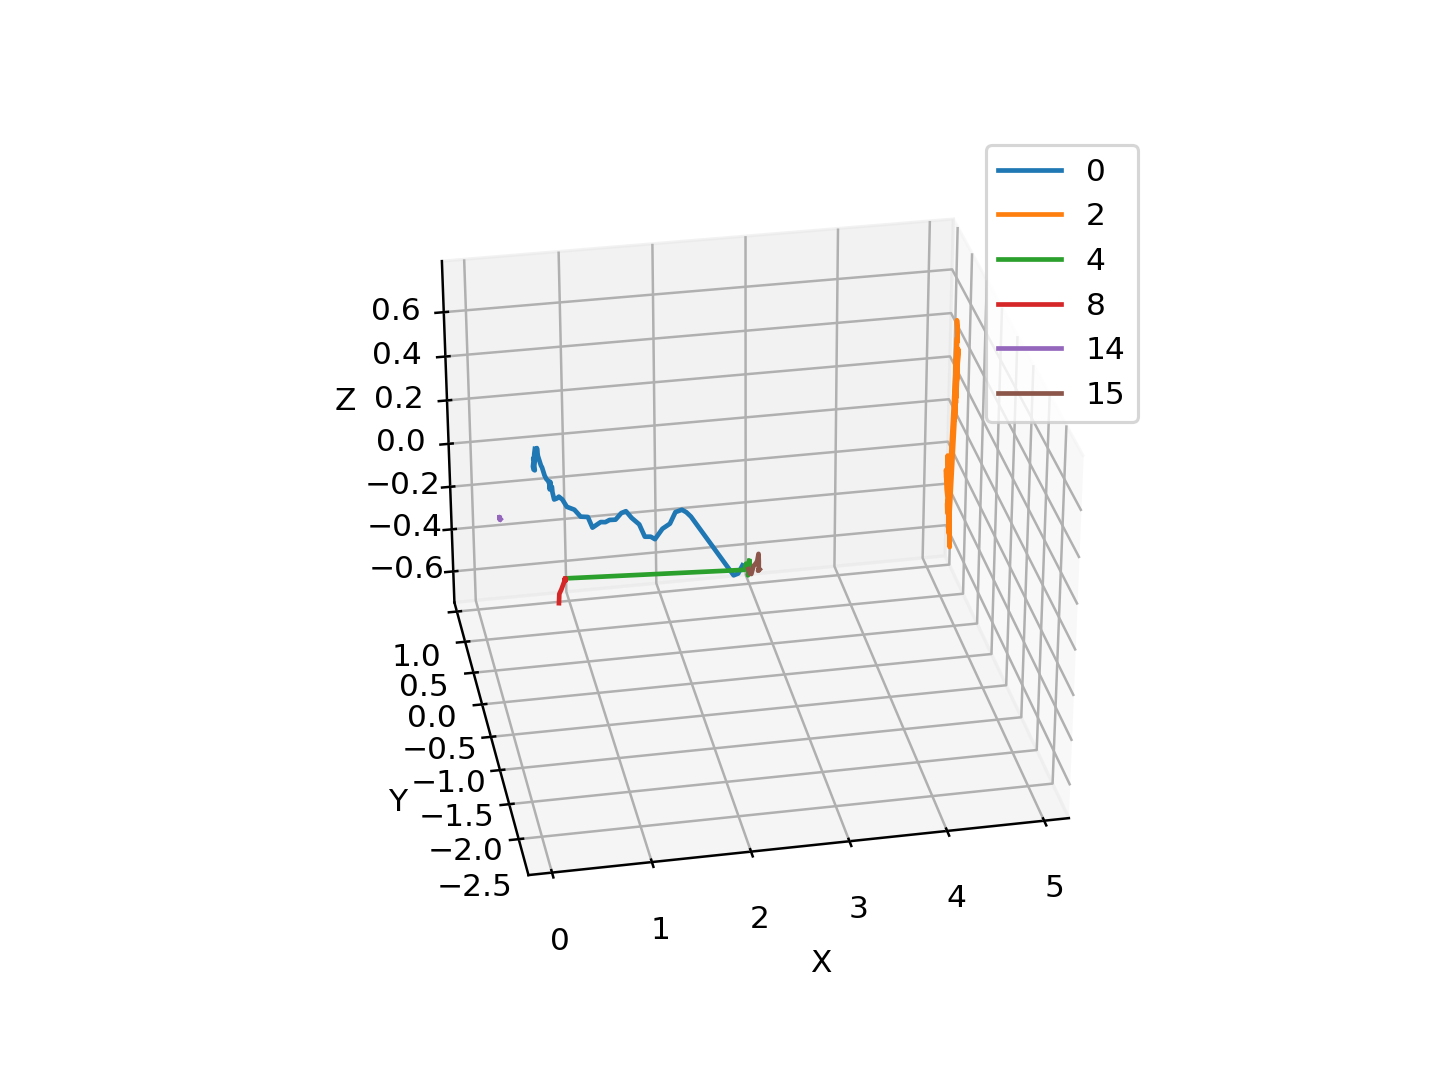

0 57
2 88
4 42
8 53
14 19
15 12


In [69]:
# Plot tracks from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

for track_num in np.unique(estimate_states.track_num):
    if len(estimate_states[estimate_states.track_num==track_num]) > DA_TRACKCOUNT:
        ax.plot(list(estimate_states[estimate_states.track_num==track_num].x), 
                list(estimate_states[estimate_states.track_num==track_num].y), 
                list(estimate_states[estimate_states.track_num==track_num].z), 
                label=str(track_num))
        print(track_num, len(estimate_states[estimate_states.track_num==track_num]))

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


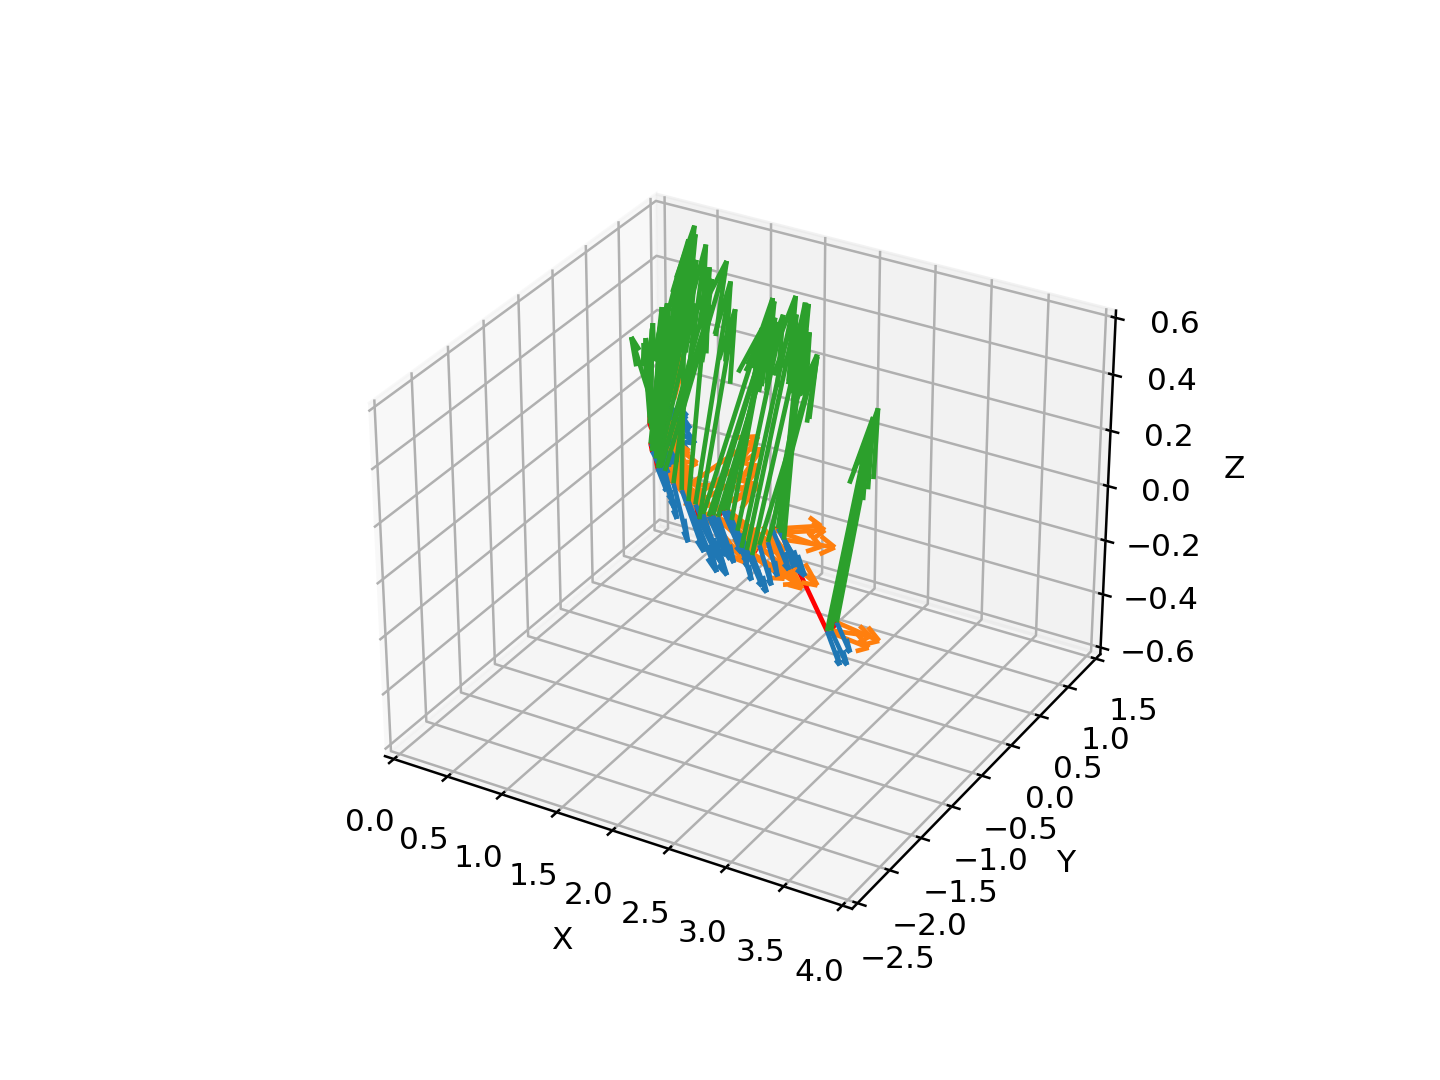

In [155]:
# Plot estimated human figure from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

for idx in list(estimate_states[estimate_states.track_num==0].index):
    orientation = np.array([estimate_states.loc[idx].ori_x,
                            estimate_states.loc[idx].ori_y, 
                            estimate_states.loc[idx].ori_z])
    center = np.array(estimate_states.loc[idx][['x','y','z']])
    extension = np.array(estimate_states.loc[idx][['l','w','h']])
    # PlotEllipsoid(ax, center, orientation*HorToVer(extension)/2)
    PlotArrow(ax, center, orientation, extension/2)

ax.plot(estimate_states[estimate_states.track_num==0].x,
        estimate_states[estimate_states.track_num==0].y,
        estimate_states[estimate_states.track_num==0].z,
        c='r')
    
ax.set_xlim(0,4)
ax.set_ylim(-2.5,1.5)
ax.set_zlim(-0.6,0.6)
plt.show()

<IPython.core.display.Javascript object>


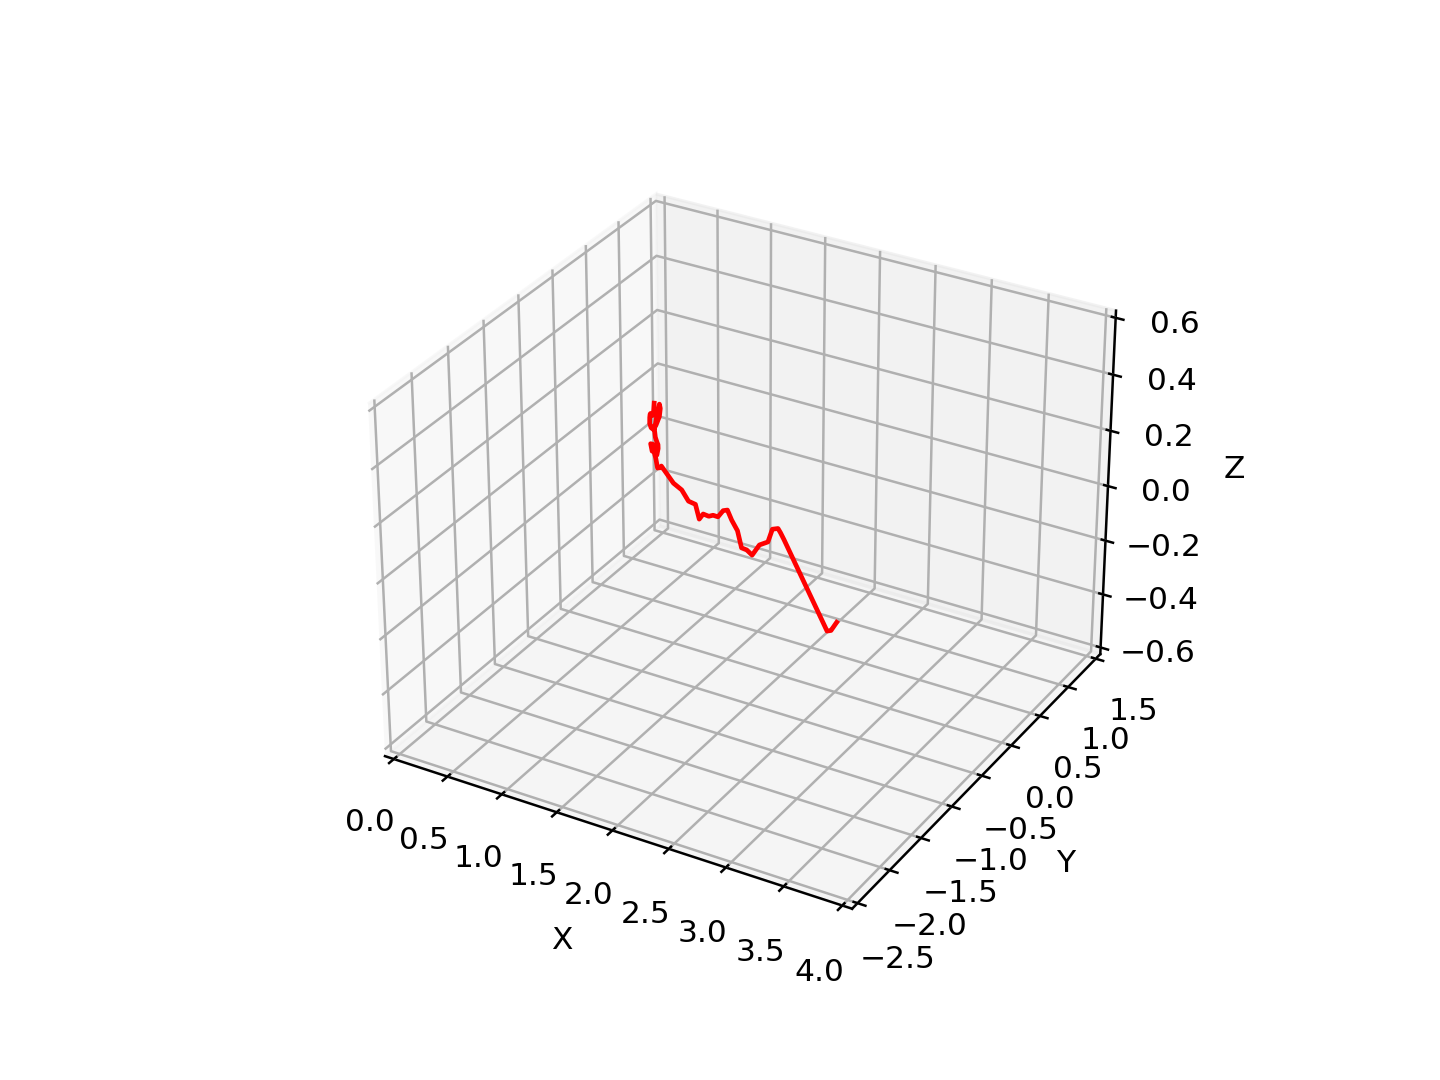

In [156]:
# Plot estimated human figure from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

ax.plot(estimate_states[estimate_states.track_num==0].x,
        estimate_states[estimate_states.track_num==0].y,
        estimate_states[estimate_states.track_num==0].z,
        c='r')
    
ax.set_xlim(0,4)
ax.set_ylim(-2.5,1.5)
ax.set_zlim(-0.6,0.6)
plt.show()

In [178]:
print(np.mean(estimate_states[estimate_states.track_num==0].h))
estimate_states[estimate_states.track_num==0].h

1.395779274879039


0      0.751888
3      0.899224
6      0.637329
9      0.553818
12     0.607308
15     0.558705
18     0.553797
21     0.717518
24     0.704678
27     0.933092
30      0.96578
33      1.04531
36      1.10016
39      1.17942
42      1.35728
45      1.49297
48      1.55841
51      1.49637
54      1.51725
56      1.44695
58      1.37479
60      1.22588
62      1.19062
64      1.03889
66      1.02434
68     0.937486
70      1.00166
72      1.15259
74      1.34966
76        1.447
78      1.62963
80      1.90164
83       2.0433
84       2.1259
85      2.17729
87      1.99436
90      1.85451
93      1.64644
96      1.67585
99      1.72478
102     1.73924
106     1.61399
110     1.66748
115     1.73269
120     1.72673
125     2.01681
129     1.86887
133     2.02678
138     1.64195
143     1.56821
147     1.56219
151     1.54104
154     1.51596
157     1.74818
190      1.6044
195     1.72081
200     1.67022
Name: h, dtype: object

### Using KF update, 100 frames

In [158]:
estimate_states_2 = GenerateEstimateStates(data, 0, 100)

Frame  0 is done.
Frame  1 is done.
Frame  2 is done.
Frame  3 is done.
Frame  4 is done.
Frame  5 is done.
Frame  6 is done.
Frame  7 is done.
Frame  8 is done.
Frame  9 is done.
Frame  10 is done.
Frame  11 is done.
Frame  12 is done.
Frame  13 is done.
Frame  14 is done.
Frame  15 is done.
Frame  16 is done.
Frame  17 is done.
Frame  18 is done.
Frame  19 is done.
Frame  20 is done.
Frame  21 is done.
Frame  22 is done.
Frame  23 is done.
Frame  24 is done.
Frame  25 is done.
Frame  26 is done.
Frame  27 is done.
Frame  28 is done.
Frame  29 is done.
Frame  30 is done.
Frame  31 is done.
Frame  32 is done.
Frame  33 is done.
Frame  34 is done.
Frame  35 is done.
Frame  36 is done.
Frame  37 is done.
Frame  38 is done.
Frame  39 is done.
Frame  40 is done.
Frame  41 is done.
Frame  42 is done.
Frame  43 is done.
Frame  44 is done.
Frame  45 is done.
Frame  46 is done.
Frame  47 is done.
Frame  48 is done.
Frame  49 is done.
Frame  50 is done.
Frame  51 is done.
Frame  52 is done.
Fra

<IPython.core.display.Javascript object>


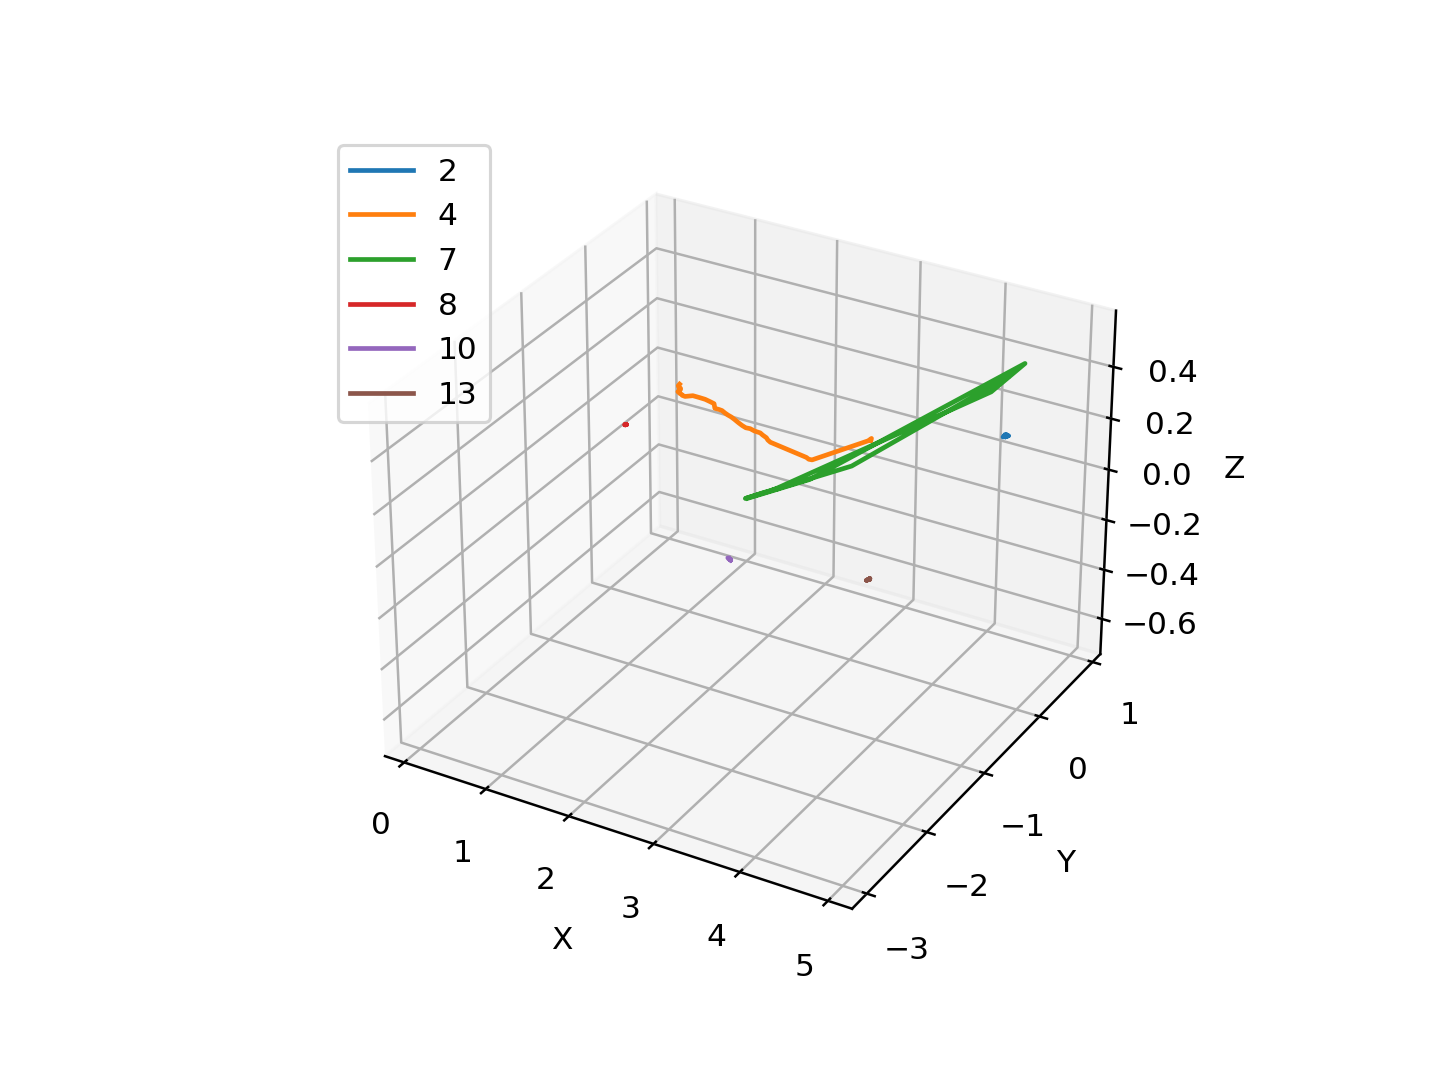

2 31
4 40
7 28
8 42
10 53
13 31


In [174]:
# Plot tracks from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

for track_num in np.unique(estimate_states_2.track_num):
    if len(estimate_states_2[estimate_states_2.track_num==track_num]) > DA_TRACKCOUNT:
        ax.plot(list(estimate_states_2[estimate_states_2.track_num==track_num].x), 
                list(estimate_states_2[estimate_states_2.track_num==track_num].y), 
                list(estimate_states_2[estimate_states_2.track_num==track_num].z), 
                label=str(track_num))
        print(track_num, len(estimate_states_2[estimate_states_2.track_num==track_num]))

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


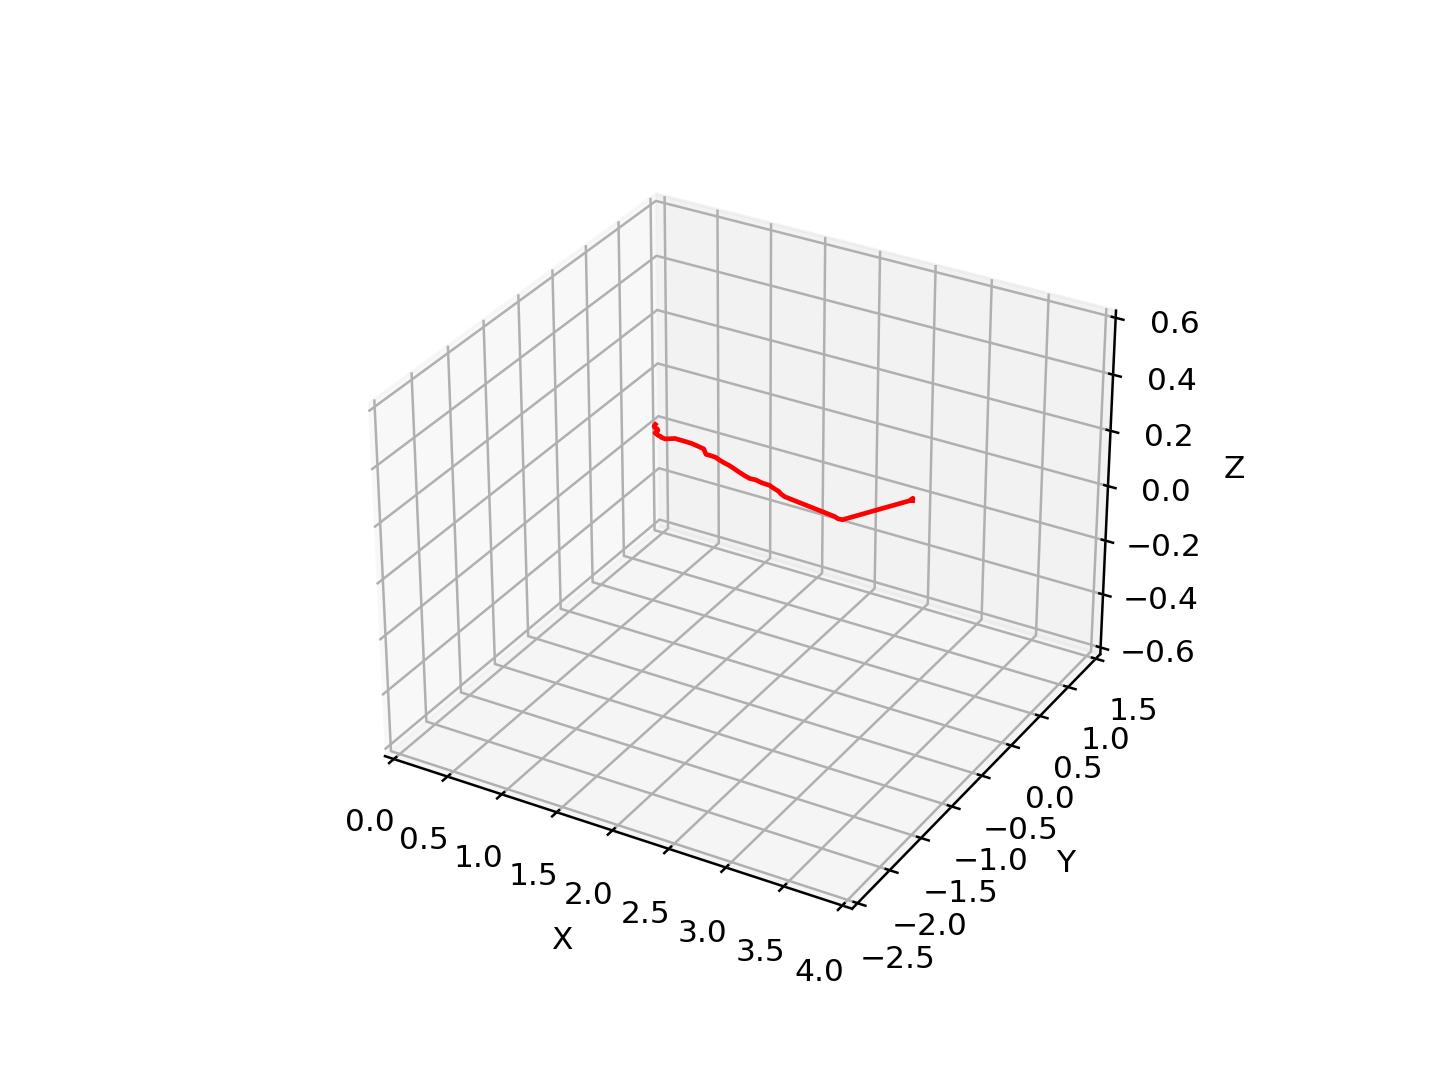

In [165]:
# Plot estimated human figure from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

ax.plot(estimate_states_2[estimate_states_2.track_num==4].x,
        estimate_states_2[estimate_states_2.track_num==4].y,
        estimate_states_2[estimate_states_2.track_num==4].z,
        c='r')
    
ax.set_xlim(0,4)
ax.set_ylim(-2.5,1.5)
ax.set_zlim(-0.6,0.6)
plt.show()

<IPython.core.display.Javascript object>


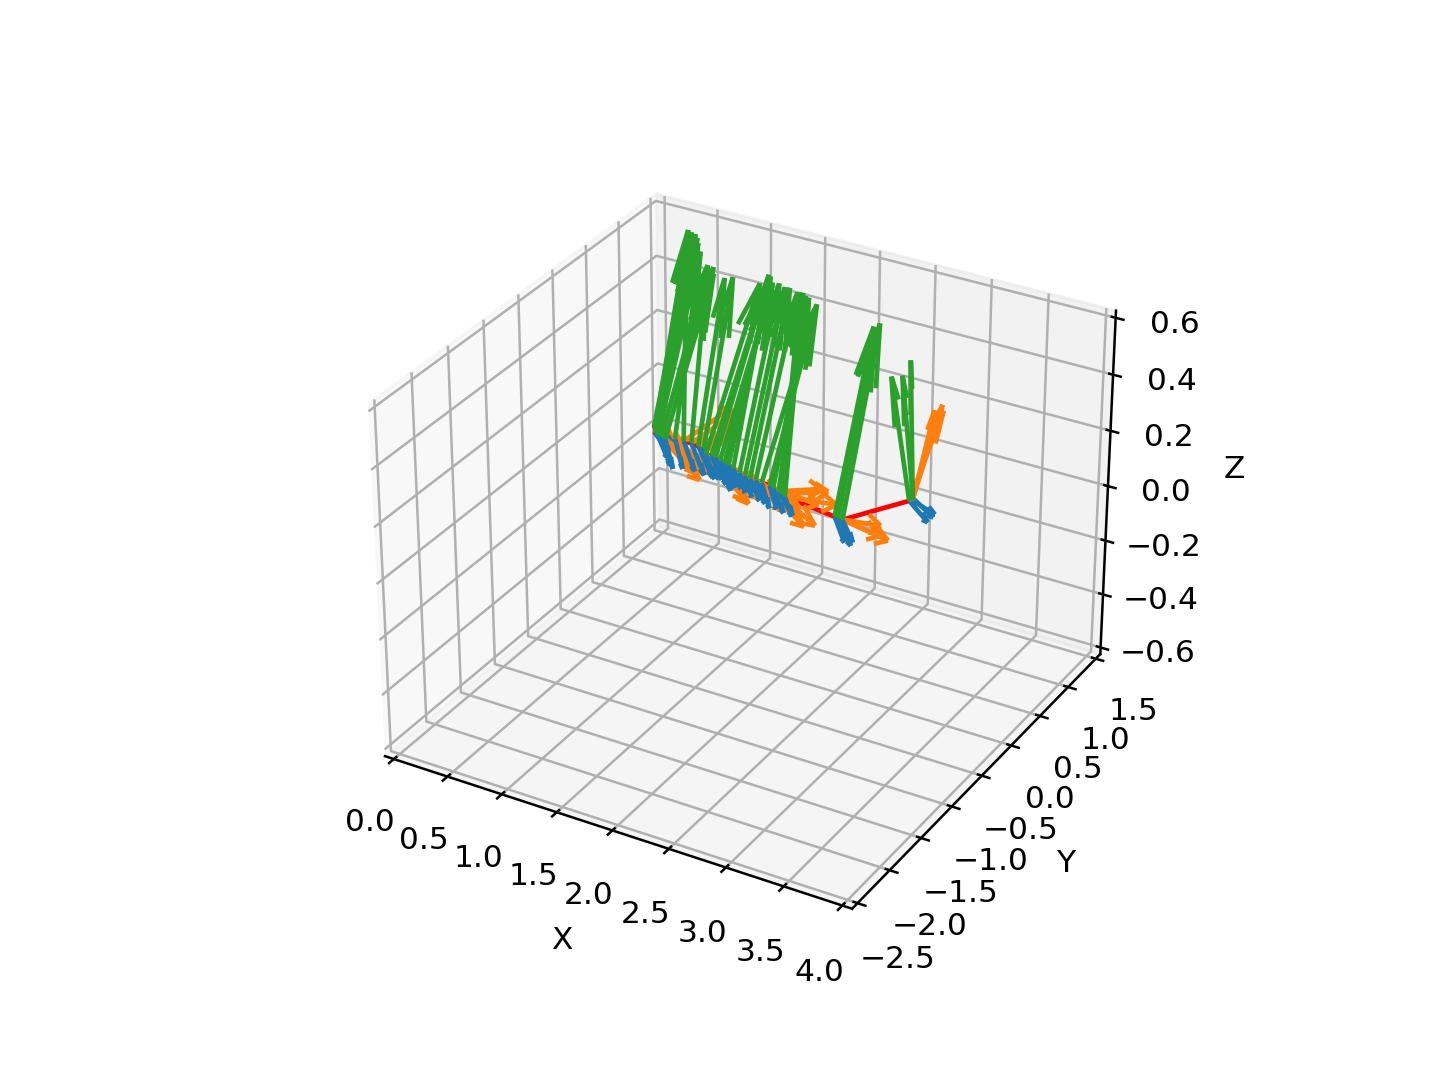

In [169]:
# Plot estimated human figure from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

for idx in list(estimate_states_2[estimate_states_2.track_num==4].index):
    orientation = np.array([estimate_states_2.loc[idx].ori_x,
                            estimate_states_2.loc[idx].ori_y, 
                            estimate_states_2.loc[idx].ori_z])
    center = np.array(estimate_states_2.loc[idx][['x','y','z']])
    extension = np.array(estimate_states_2.loc[idx][['l','w','h']])
    # PlotEllipsoid(ax, center, orientation*HorToVer(extension)/2)
    PlotArrow(ax, center, orientation, extension/2)

ax.plot(estimate_states_2[estimate_states_2.track_num==4].x,
        estimate_states_2[estimate_states_2.track_num==4].y,
        estimate_states_2[estimate_states_2.track_num==4].z,
        c='r')
    
ax.set_xlim(0,4)
ax.set_ylim(-2.5,1.5)
ax.set_zlim(-0.6,0.6)
plt.show()

In [177]:
print(np.mean(estimate_states_2[estimate_states_2.track_num==4].h))
estimate_states_2[estimate_states_2.track_num==4].h

1.4931530799760577


47     1.49297
50     1.49298
53     1.49297
55     1.49297
57     1.49297
59     1.49296
61     1.49289
63      1.4928
75     1.49274
77     1.49268
79     1.49266
80     1.49272
83     1.49287
84     1.49301
85     1.49314
87     1.49324
90     1.49329
93     1.49326
96     1.49325
99     1.49326
102    1.49329
106    1.49323
110    1.49319
115    1.49318
120    1.49318
125    1.49331
129    1.49337
133    1.49351
138    1.49347
143    1.49343
147    1.49334
151    1.49322
154    1.49312
157    1.49316
190    1.49309
195    1.49314
200    1.49315
216    1.49355
220    1.49379
224     1.4938
Name: h, dtype: object

## Test on all frames

In [181]:
startFrame = 0
endFrame = np.max(data.frame_num)

observation_states = GenerateObservationStates(data, startFrame, startFrame, orientation=True)
estimate_states = InitEstimateState(observation_states, startFrame)

for frame_num in range(startFrame+1, endFrame+1):
    observation_states = GenerateObservationStates(data, frame_num, frame_num, orientation=True)
    observation_states = ClusterTrackMapping(frame_num, observation_states, estimate_states)
    estimate_states = KF_Update(frame_num, observation_states, estimate_states, debug=False)


Frame  0 is done.
Frame  1 is done.
Frame  2 is done.
Frame  3 is done.
Frame  4 is done.
Frame  5 is done.
Frame  6 is done.
Frame  7 is done.
Frame  8 is done.
Frame  9 is done.
Frame  10 is done.
Frame  11 is done.
Frame  12 is done.
Frame  13 is done.
Frame  14 is done.
Frame  15 is done.
Frame  16 is done.
Frame  17 is done.
Frame  18 is done.
Frame  19 is done.
Frame  20 is done.
Frame  21 is done.
Frame  22 is done.
Frame  23 is done.
Frame  24 is done.
Frame  25 is done.
Frame  26 is done.
Frame  27 is done.
Frame  28 is done.
Frame  29 is done.
Frame  30 is done.
Frame  31 is done.
Frame  32 is done.
Frame  33 is done.
Frame  34 is done.
Frame  35 is done.
Frame  36 is done.
Frame  37 is done.
Frame  38 is done.
Frame  39 is done.
Frame  40 is done.
Frame  41 is done.
Frame  42 is done.
Frame  43 is done.
Frame  44 is done.
Frame  45 is done.
Frame  46 is done.
Frame  47 is done.
Frame  48 is done.
Frame  49 is done.
Frame  50 is done.
Frame  51 is done.
Frame  52 is done.
Fra

Frame  416 is done.
Frame  417 is done.
Frame  418 is done.
Frame  419 is done.
Frame  420 is done.
Frame  421 is done.
Frame  422 is done.
Frame  423 is done.
Frame  424 is done.
Frame  425 is done.
Frame  426 is done.
Frame  427 is done.
Frame  428 is done.
Frame  429 is done.
Frame  430 is done.
Frame  431 is done.
Frame  432 is done.
Frame  433 is done.
Frame  434 is done.
Frame  435 is done.
Frame  436 is done.
Frame  437 is done.
Frame  438 is done.
Frame  439 is done.
Frame  440 is done.
Frame  441 is done.
Frame  442 is done.
Frame  443 is done.
Frame  444 is done.
Frame  445 is done.
Frame  446 is done.
Frame  447 is done.
Frame  448 is done.
Frame  449 is done.
Frame  450 is done.
Frame  451 is done.
Frame  452 is done.
Frame  453 is done.
Frame  454 is done.
Frame  455 is done.
Frame  456 is done.
Frame  457 is done.
Frame  458 is done.
Frame  459 is done.
Frame  460 is done.
Frame  461 is done.
Frame  462 is done.
Frame  463 is done.
Frame  464 is done.
Frame  465 is done.


Frame  826 is done.
Frame  827 is done.
Frame  828 is done.
Frame  829 is done.
Frame  830 is done.
Frame  831 is done.
Frame  832 is done.
Frame  833 is done.
Frame  834 is done.
Frame  835 is done.
Frame  836 is done.
Frame  837 is done.
Frame  838 is done.
Frame  839 is done.
Frame  840 is done.
Frame  841 is done.
Frame  842 is done.
Frame  843 is done.
Frame  844 is done.
Frame  845 is done.
Frame  846 is done.
Frame  847 is done.
Frame  848 is done.
Frame  849 is done.
Frame  850 is done.
Frame  851 is done.
Frame  852 is done.
Frame  853 is done.
Frame  854 is done.
Frame  855 is done.
Frame  856 is done.
Frame  857 is done.
Frame  858 is done.
Frame  859 is done.
Frame  860 is done.
Frame  861 is done.
Frame  862 is done.
Frame  863 is done.
Frame  864 is done.
Frame  865 is done.
Frame  866 is done.
Frame  867 is done.
Frame  868 is done.
Frame  869 is done.
Frame  870 is done.
Frame  871 is done.
Frame  872 is done.
Frame  873 is done.
Frame  874 is done.
Frame  875 is done.


<IPython.core.display.Javascript object>


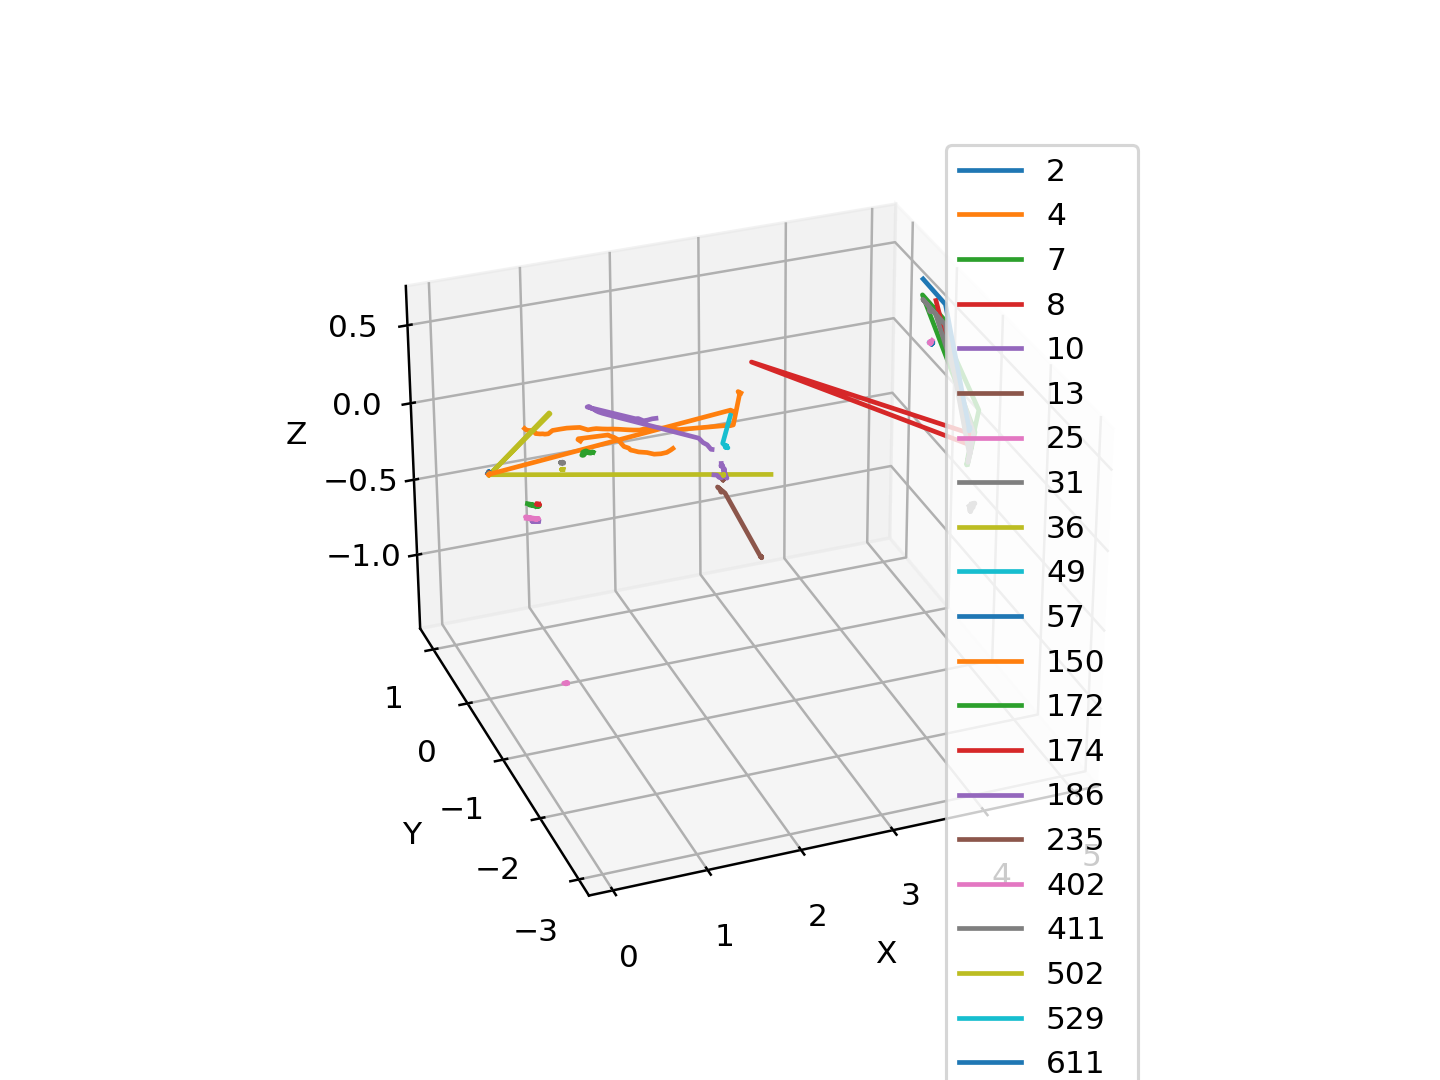

2 31
4 40
7 28
8 56
10 149
13 47
25 26
31 23
36 75
49 28
57 85
150 21
172 137
174 40
186 28
235 25
402 229
411 40
502 40
529 21
611 21
730 99
823 21
881 34
903 21
955 21
964 25
1024 31
1114 27


In [214]:
# Plot tracks from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

for track_num in np.unique(estimate_states.track_num):
    if len(estimate_states[estimate_states.track_num==track_num]) > DA_TRACKCOUNT:
        ax.plot(list(estimate_states[estimate_states.track_num==track_num].x), 
                list(estimate_states[estimate_states.track_num==track_num].y), 
                list(estimate_states[estimate_states.track_num==track_num].z), 
                label=str(track_num))
        print(track_num, len(estimate_states[estimate_states.track_num==track_num]))

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


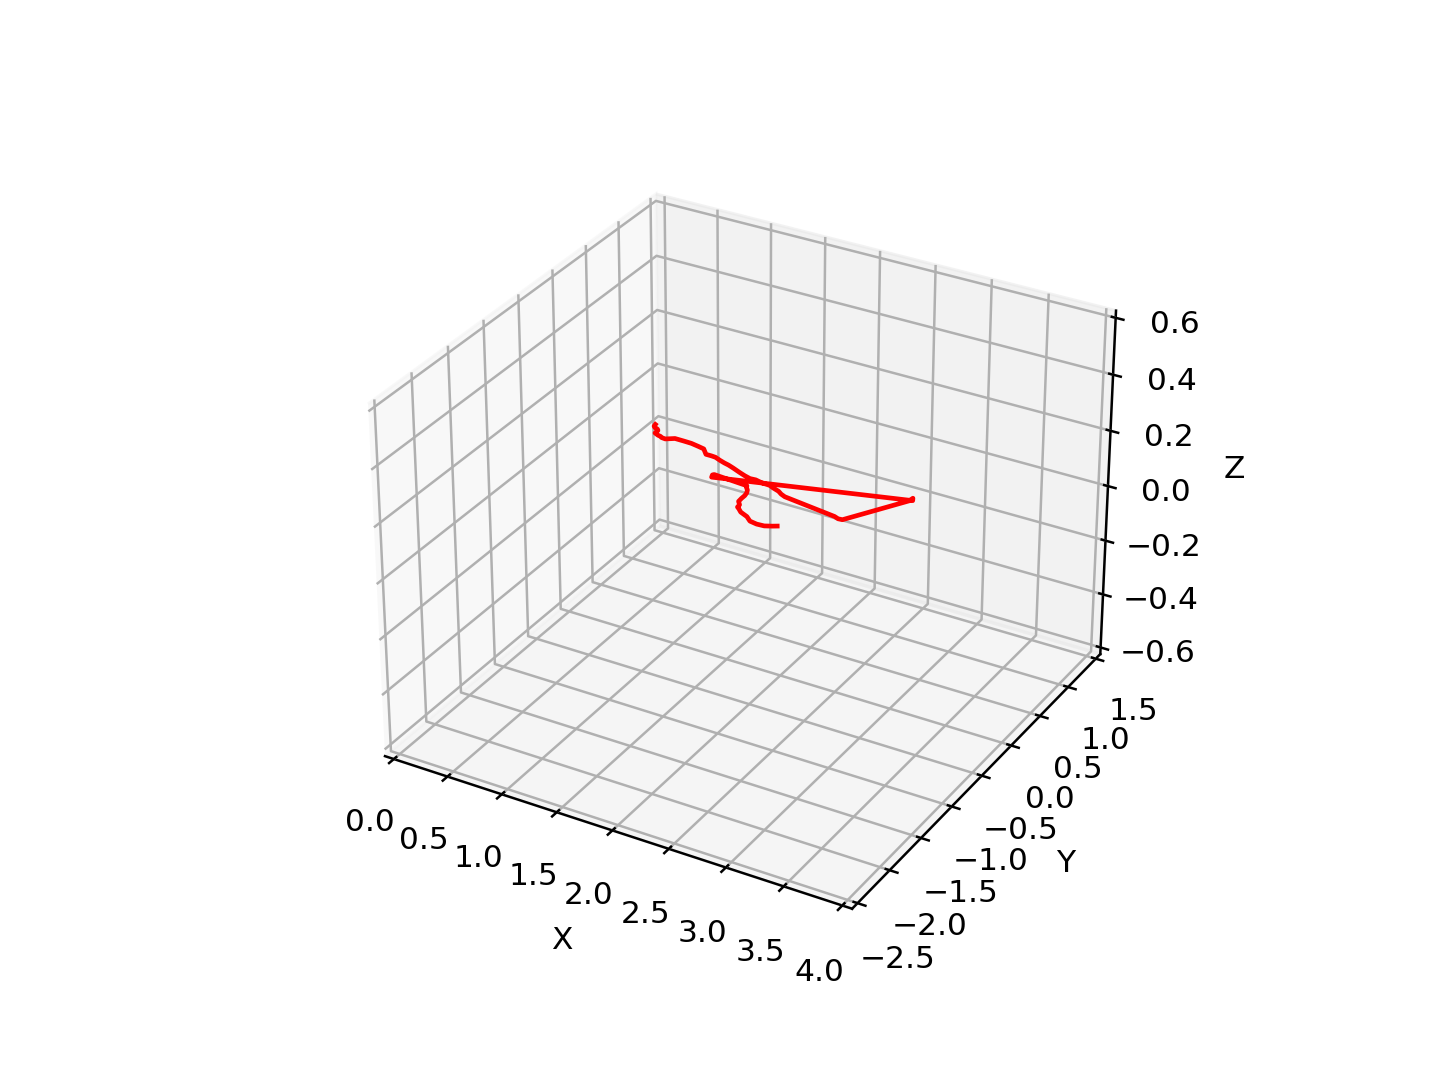

In [212]:
# Plot estimated human figure from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

ax.plot(estimate_states[(estimate_states.track_num==150)|(estimate_states.track_num==4)].x,
        estimate_states[(estimate_states.track_num==150)|(estimate_states.track_num==4)].y,
        estimate_states[(estimate_states.track_num==150)|(estimate_states.track_num==4)].z,
        c='r')
    
ax.set_xlim(0,4)
ax.set_ylim(-2.5,1.5)
ax.set_zlim(-0.6,0.6)
plt.show()

<IPython.core.display.Javascript object>


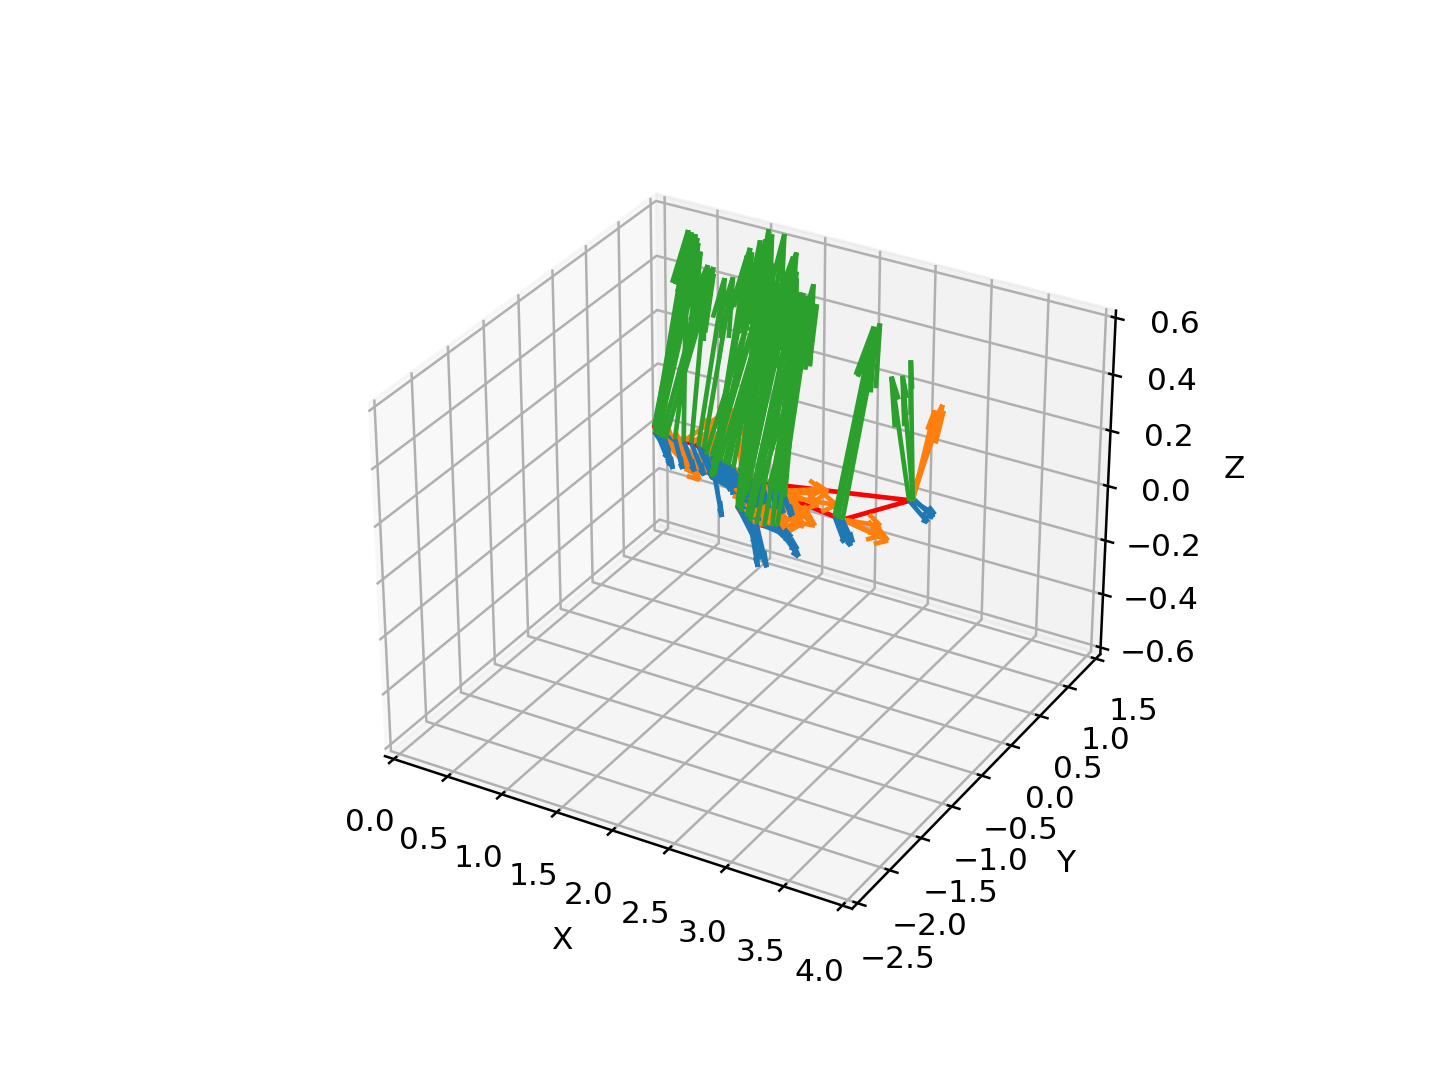

In [208]:
# Plot estimated human figure from estimate_states
fig = plt.figure()
ax = fig.gca(projection = '3d')
PlotSetting(ax)

for idx in list(estimate_states[(estimate_states.track_num==150)|(estimate_states.track_num==4)].index):
    orientation = np.array([estimate_states.loc[idx].ori_x,
                            estimate_states.loc[idx].ori_y, 
                            estimate_states.loc[idx].ori_z])
    center = np.array(estimate_states.loc[idx][['x','y','z']])
    extension = np.array(estimate_states.loc[idx][['l','w','h']])
    # PlotEllipsoid(ax, center, orientation*HorToVer(extension)/2)
    PlotArrow(ax, center, orientation, extension/2)

ax.plot(estimate_states[(estimate_states.track_num==150)|(estimate_states.track_num==4)].x,
        estimate_states[(estimate_states.track_num==150)|(estimate_states.track_num==4)].y,
        estimate_states[(estimate_states.track_num==150)|(estimate_states.track_num==4)].z,
        c='r')
    
ax.set_xlim(0,4)
ax.set_ylim(-2.5,1.5)
ax.set_zlim(-0.6,0.6)
plt.show()

In [216]:
print("Frame range:", np.min(estimate_states[estimate_states.track_num==150].frame_num), 'to', np.max(estimate_states[estimate_states.track_num==150].frame_num))
print("L=", np.mean(estimate_states[estimate_states.track_num==150].l))
print("W=", np.mean(estimate_states[estimate_states.track_num==150].w))
print("H=", np.mean(estimate_states[estimate_states.track_num==150].h))


Frame range: 226 to 253
L= 0.4605296037364003
W= 0.7532949922846951
H= 1.891867577529014


## Debug: Data association need debugging (track initialization, redundant track)

In [275]:
endFrame = 100
observation_states = GenerateObservationStates(data, 0, endFrame, orientation=True)
estimate_states = InitEstimateState(observation_states, 0)


Frame  0 is done.
Frame  1 is done.
Frame  2 is done.
Frame  3 is done.
Frame  4 is done.
Frame  5 is done.
Frame  6 is done.
Frame  7 is done.
Frame  8 is done.
Frame  9 is done.
Frame  10 is done.
Frame  11 is done.
Frame  12 is done.
Frame  13 is done.
Frame  14 is done.
Frame  15 is done.
Frame  16 is done.
Frame  17 is done.
Frame  18 is done.
Frame  19 is done.
Frame  20 is done.
Frame  21 is done.
Frame  22 is done.
Frame  23 is done.
Frame  24 is done.
Frame  25 is done.
Frame  26 is done.
Frame  27 is done.
Frame  28 is done.
Frame  29 is done.
Frame  30 is done.
Frame  31 is done.
Frame  32 is done.
Frame  33 is done.
Frame  34 is done.
Frame  35 is done.
Frame  36 is done.
Frame  37 is done.
Frame  38 is done.
Frame  39 is done.
Frame  40 is done.
Frame  41 is done.
Frame  42 is done.
Frame  43 is done.
Frame  44 is done.
Frame  45 is done.
Frame  46 is done.
Frame  47 is done.
Frame  48 is done.
Frame  49 is done.
Frame  50 is done.
Frame  51 is done.
Frame  52 is done.
Fra

In [315]:
observation_states

frame_num cluster_num track_num         x         y          z         l  \
0           0          -1        -1       NaN       NaN        NaN       NaN   
1           0           0         0  0.566873  0.452257   0.130958    0.4221   
2           0           1         1   2.88129  0.513038  -0.494942  0.425445   
3           0           2         2   4.88947 -0.178891   0.363762   0.15849   
4           1          -1        -1       NaN       NaN        NaN       NaN   
..        ...         ...       ...       ...       ...        ...       ...   
442       100          -1        -1       NaN       NaN        NaN       NaN   
443       100           0         0  0.117874  0.138662 -0.0820208  0.120269   
444       100           1         1  0.942558  0.882099  -0.611363   1.16931   
445       100           2         2   2.87987  0.528597  -0.502297  0.287839   
446       100           3         3   4.89016 -0.186249   0.480105  0.189625   

            w         h                                              ori_x  \
0         NaN       NaN                                                NaN   
1    0.794529  0.751888  [0.9938633377363293, -0.10806609548316558, -0....   
2    0.276738    1.3812  [0.6876513464024218, 0.669717547943948, -0.280...   
3    0.391652   2.21361  [0.9967752491095346, 0.0627005982260056, -0.05...   
4         NaN       NaN                                                NaN   
..        ...       ...                                                ...   
442       NaN       NaN                                                NaN   
443  0.234441  0.806981  [0.8201372977004592, -0.5407003148487831, 0.18...   
444  0.093375  0.369716  [0.8988277990541022, -0.11621845137298259, 0.4...   
445  0.486941  0.985639  [0.7488573917471476, -0.6622769832649209, 0.02...   
446  0.340753   2.15297  [0.9986963609925066, -0.04881056086062661, 0.0...   

                                                 ori_y  \
0                                                  NaN   
1    [0.08439314476724513, 0.8787682611187487, -0.4...   
2    [-0.6924111868086408, 0.7210961923677758, 0.02...   
3    [-0.06523240027478272, 0.9965846613521786, -0....   
4                                                  NaN   
..                                                 ...   
442                                                NaN   
443  [0.5456129680076878, 0.8375435280225917, 0.028...   
444  [0.34577860210206157, 0.7805383767678663, -0.5...   
445  [0.6569559704167016, 0.7369468309025948, -0.15...   
446  [0.05071782255954468, 0.9819347120289765, -0.1...   

                                                 ori_z  \
0                                                  NaN   
1    [0.07150848215350519, 0.46485273179508585, 0.8...   
2    [0.21840873190691448, 0.17747869542184794, 0.9...   
3    [0.04673153878287673, 0.053736837827179966, 0....   
4                                                  NaN   
..                                                 ...   
442                                                NaN   
443  [-0.1722826226362622, 0.07851119786309463, 0.9...   
444  [-0.26934317510548295, 0.614209340496422, 0.74...   
445  [0.08730097227126617, 0.13527219174737432, 0.9...   
446  [-0.005768970024518949, 0.18281616575413173, 0...   

                                                   cov  \
0                                                  NaN   
1    [[0.005093768596522934, 0.0012909219139843372,...   
2    [[0.005925258896142387, 0.003307460216444924, ...   
3    [[0.0010086382857060353, 0.0001084177317351348...   
4                                                  NaN   
..                                                 ...   
442                                                NaN   
443  [[0.0012616733771430258, 0.0002748274983248639...   
444  [[0.030988092888323517, -0.004530174046311608,...   
445  [[0.004338926847505411, 0.0023660496839534853,...   
446  [[0.0010087996946585801, -2.3857207122520868e-...   

               

In [344]:
# DA tracking info
def InitTrackDataFrame():
    return pd.DataFrame(columns=['track_num', 'frame_num', 'cluster_num', 'tentative', 'history', 'frame_count', 'multiplicity', 'quality'])

In [345]:
# Initialize track_states
def InitTrackStates(observation_states, frame_num):
    track_states = InitTrackDataFrame()
    for cluster_num in np.unique(observation_states[(observation_states.frame_num==frame_num)&(observation_states.cluster_num!=-1)].cluster_num):
        track_state = InitTrackDataFrame()
        track_state.at[0, 'track_num'] = cluster_num          # Corresponding to track_num in estimate_states
        track_state.at[0, 'frame_num'] = frame_num            # Last frame_num where this track exists
        track_state.at[0, 'cluster_num'] = cluster_num        # Corresponding to cluster_num in observation_states
        track_state.at[0, 'tentative'] = True                 # For track initialization (m/n rule)
        track_state.at[0, 'history'] = [frame_num]            # List of frame_num where the track exists (for m/n rule: length of list compare with m)
        track_state.at[0, 'frame_count'] = 1                  # For track initialization (m/n rule: compare with n)
        track_state.at[0, 'multiplicity'] = 1                 # For redundant track removal
        track_state.at[0, 'quality'] = 1                      # Range from 0 (worst) to 1 (best), for redundant track removal
        
        track_states = track_states.append(track_state, ignore_index=True)
    return track_states

In [346]:
track_states = InitTrackStates(observation_states, 0)
track_states

track_num frame_num cluster_num tentative history frame_count multiplicity  \
0         0         0           0      True     [0]           1            1   
1         1         0           1      True     [0]           1            1   
2         2         0           2      True     [0]           1            1   

  quality  
0       1  
1       1  
2       1

### Step-by-step data association testing

In [351]:
frame_num += 1
print(frame_num)

0


In [352]:
z_state, z_cov = GenerateZstates(frame_num, observation_states)
s_state, s_cov = GenerateSstates(frame_num, estimate_states)
n_count = list(np.unique(z_state.cluster_num)) # Existing cluster number at current frame_num
t_count = list(np.unique(s_state.track_num)) # Existing track number

g_matrix = ClusterTrackLikelihood(z_state, z_cov, s_state, s_cov)
score_matrix = ClusterTrackScoreMatrix(g_matrix)
print(score_matrix)


NameError: name 'DA_TRACKGAP' is not defined

In [327]:
# Low-pass filter on score_matrix
for n in range(len(n_count)):
    for t in range(len(t_count)):
        if score_matrix[n, t] < DA_THRESHOLD:
            score_matrix[n, t] = 0
print(score_matrix)


[[0.99999769 0.         0.        ]
 [0.         0.99999663 0.        ]
 [0.         0.         0.99999462]]


In [305]:
track_max = np.max(estimate_states[estimate_states.frame_num<frame_num].track_num)
mapping_track_idx = linear_sum_assignment(score_matrix, maximize=True)[1] # Hungarian Algorithm, column index

for i in range(len(n_count)):
    print('Cluster=', i, '\tTrack=', mapping_track_idx[i], '\tScore=', score_matrix[i, mapping_track_idx[i]])

Cluster= 0 	Track= 0 	Score= 0.9999976885222468
Cluster= 1 	Track= 1 	Score= 0.9999966287583021
Cluster= 2 	Track= 2 	Score= 0.99999461792818


In [306]:
for i in range(len(n_count)):
    if score_matrix[i, mapping_track_idx[i]] >= DA_THRESHOLD:
        # i-th cluster in n_count ↔ mapping_idx[i]-th track in t_count
        z_state.at[z_state[z_state.cluster_num==n_count[i]].index[0], 'track_num'] = t_count[mapping_track_idx[i]]
    else:
        # i-th cluster in n_count ↔ new (++track_max) track
        track_max += 1
        z_state.at[z_state[z_state.cluster_num==n_count[i]].index[0], 'track_num'] = track_max

z_state[['cluster_num', 'track_num']]

cluster_num track_num
5           0         0
6           1         1
7           2         2

In [307]:
for i in list(z_state.index):
    observation_states.at[i, 'track_num'] = z_state.track_num[i]

estimate_states = KF_Update(frame_num, observation_states, estimate_states)